In [1]:
import warnings
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pkl

In [2]:
def elo_odds(ra, rb):
    ea = 1/(1 + 10**((rb-ra)/400))
    return ea

def elo_match(ra, rb, k):
    '''Calculates new ratings new_ra, new_rb for a match where A (with initial rating ra) wins, and B (with initial rating rb) loses.'''
    # odds
    ea = elo_odds(ra, rb)

    # new score
    dscore = np.asarray(0.5+ k * (1-ea)).astype(int) # a is the winner by definition
    new_ra = ra + dscore
    new_rb = rb - dscore

    return new_ra, new_rb

Text(0, 0.5, 'Odds of winning')

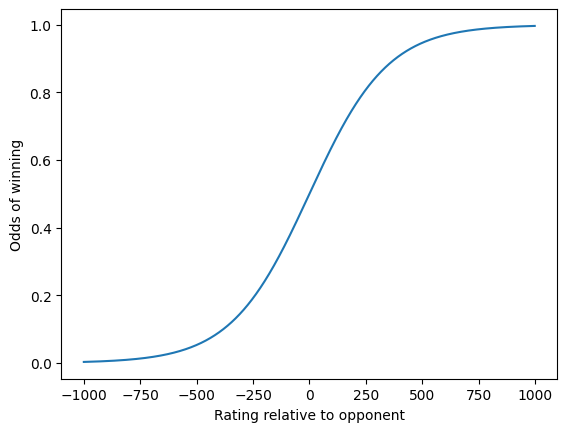

In [3]:
x = np.arange(-1000, 1000)
plt.plot(x, elo_odds(x, 0))
plt.xlabel('Rating relative to opponent')
plt.ylabel('Odds of winning')

Text(0, 0.5, 'Rating change after winning')

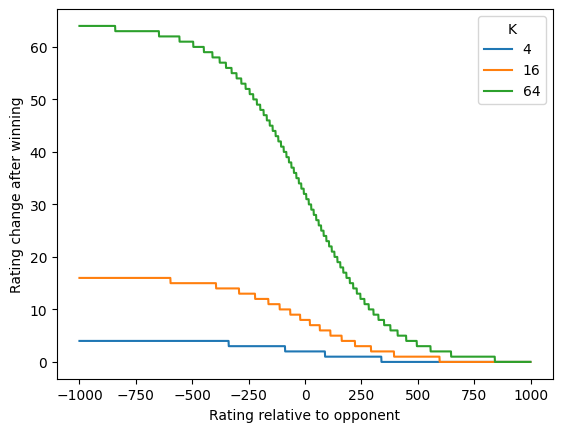

In [4]:
for k in (4, 16, 64):
    y, _ = elo_match(x, 0, k)
    plt.plot(x, y-x, label=k)
plt.legend(title='K')
plt.xlabel('Rating relative to opponent')
plt.ylabel('Rating change after winning')

In [3]:
def get_ratings(details, k=16, dims=('novelty', 'feasibility', 'value')):
    df_melted = pd.melt(details, id_vars=['Item', 'Type'], value_vars=['Winner', 'Loser'], var_name='Outcome', value_name='Answer')
    match_counts = df_melted.groupby(['Item', 'Answer','Type']).size().reset_index().rename(columns={0:'N'})
    match_counts['processed'] = 0
    match_counts[0] = 1600
    meta = {dim: match_counts[match_counts.Type == dim][['Item', 'Answer', 'N', 'processed', 0]].copy().reset_index(drop=True) for dim in dims}
    elo = {dim: [mdim[0]] for dim, mdim in meta.items()}

    for i, row in details.iterrows():
        # row selection
        mdim, edim = meta[row.Type], elo[row.Type]
        item = mdim.Item.values == row.Item
        # Note: Treat A, B as read-only, since they *could* be copies. For writing, use edim.loc[A.name, <cols>] = values
        A = mdim.loc[item & (mdim.Answer.values == row.Winner)].iloc[0]
        B = mdim.loc[item & (mdim.Answer.values == row.Loser)].iloc[0]

        # ratings before the match
        ra = edim[A.processed][A.name]
        rb = edim[B.processed][B.name]

        # ratings after A wins
        new_ra, new_rb = elo_match(ra, rb, k)

        # update processing count
        mdim.loc[[A.name, B.name], 'processed'] = nA, nB = A.processed+1, B.processed+1
        
        # insert column if necessary
        nMax = max(nA, nB)
        if len(edim) <= nMax:
            edim.append(edim[0].copy().rename(nMax))

        # update
        edim[nA].loc[A.name] = new_ra
        edim[nB].loc[B.name] = new_rb
    
    # Join
    joined = {dim: mdim.loc[:, :'processed'].join(pd.concat(elo[dim], axis=1)) for dim, mdim in meta.items()}

    # Fill in beyond N
    for edim in joined.values():
        assert np.all(edim.N == edim.processed)
        for i, row in edim.iterrows():
            if row.N+1 in edim:
                edim.loc[i, row.N+1:] = row[row.N]

    return joined

In [4]:
indicator = .9

# Match to rank (odds = 1)

In [7]:
n = 40
half = n//2
matches = 100
rank_elo = []
for _ in range(10):
    elo_list = [pd.Series(np.full(n, 1600, int))]
    target_rank = np.random.choice(n, n, replace=False)
    for i in range(matches):
        candidates = np.random.choice(n, n, replace=False)
        outcomes = target_rank[candidates[:half]] > target_rank[candidates[half:]]
        winners = np.where(outcomes, candidates[:half], candidates[half:])
        losers = np.where(outcomes, candidates[half:], candidates[:half])
        winner_elo, loser_elo = elo_match(elo_list[-1][winners].values, elo_list[-1][losers].values, k=16)
        sorted_elo = pd.Series(np.empty(n, int))
        sorted_elo.loc[winners] = winner_elo
        sorted_elo.loc[losers] = loser_elo
        elo_list.append(sorted_elo)
    rank_elo.append(pd.DataFrame({'target': target_rank}).join(pd.concat(elo_list, axis=1)))

(0.0, 1.0235963039728277)

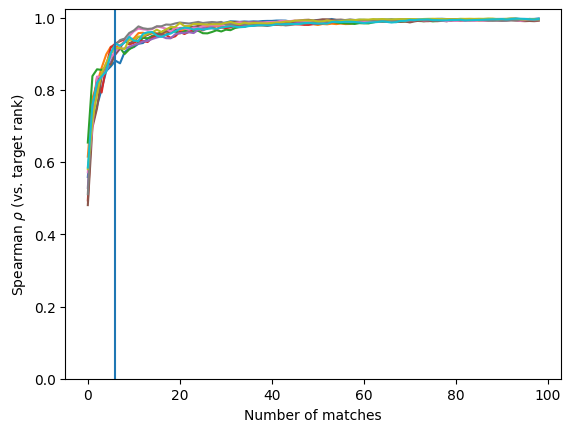

In [8]:
corrs = []
for i, eshuf in enumerate(rank_elo):
    corr = np.empty(matches-1)
    for m in range(matches-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    plt.plot(corr)
    corrs.append(corr)
plt.axvline(np.argmax(np.mean(corrs, axis=0) > indicator))

plt.xlabel('Number of matches')
plt.ylabel('Spearman $\\rho$ (vs. target rank)')
plt.ylim(0, None)

# Match to Elo ratings

In [9]:
target_ranges = (250, 500, 1000)
elo_odds(np.zeros_like(target_ranges), np.asarray(target_ranges))

array([0.19168233, 0.05324022, 0.00315231])

In [10]:
n = 40
half = n//2
matches = 100
range_elo = {}
range_winners = {}
range_losers = {}
for target_range in target_ranges:
    range_elo[target_range] = []
    range_winners[target_range] = []
    range_losers[target_range] = []
    for _ in range(10):
        elo_list = [pd.Series(np.full(n, 1600, int))]
        winner_list, loser_list = [], []
        target_elo = np.random.choice(target_range, n, replace=True) + 1600 - target_range//2
        for i in range(matches):
            candidates = np.random.choice(n, n, replace=False)
            odds = elo_odds(target_elo[candidates[:half]], target_elo[candidates[half:]])
            dice = np.random.uniform(size=half)
            outcomes = odds > dice
            winners = np.where(outcomes, candidates[:half], candidates[half:])
            losers = np.where(outcomes, candidates[half:], candidates[:half])
            winner_elo, loser_elo = elo_match(elo_list[-1][winners].values, elo_list[-1][losers].values, k=16)
            sorted_elo = pd.Series(np.empty(n, int))
            sorted_elo.loc[winners] = winner_elo
            sorted_elo.loc[losers] = loser_elo
            elo_list.append(sorted_elo)
            winner_list.append(winners)
            loser_list.append(losers)
        range_elo[target_range].append(pd.DataFrame({'target': target_elo}).join(pd.concat(elo_list, axis=1)))
        range_winners[target_range].append(np.concatenate(winner_list))
        range_losers[target_range].append(np.concatenate(loser_list))

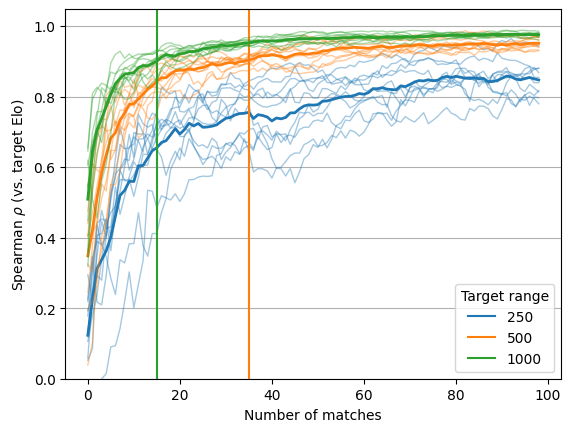

In [11]:
for i, (target_range, sim_elo) in enumerate(range_elo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    corrs = []
    for eshuf in sim_elo:
        corr = np.empty(matches-1)
        for m in range(matches-1):
            corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
        plt.plot(corr, c=f'C{i}', alpha=.4, lw=1)
        corrs.append(corr)
    corrs = np.mean(corrs, axis=0)
    plt.plot(corrs, c=f'C{i}', lw=2)
    if (corrs > indicator).sum():
        plt.axvline(np.argmax(corrs > indicator), c=f'C{i}')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend(title='Target range')

In [12]:
match_limit = 15
resample_fictive = {}
for target_range, sim_elo in range_elo.items():
    fictive = pd.DataFrame({'Item': 0, 'Type': 'mydim', 'Winner': range_winners[target_range][0][:match_limit*half], 'Loser': range_losers[target_range][0][:match_limit*half]})
    resample_fictive[target_range] = [
        pd.merge(
            get_ratings(pd.concat([fictive.loc[np.random.choice(len(fictive), len(fictive), replace=False)] for i in range(5)]), dims=['mydim'])['mydim'],
            sim_elo[0]['target'], left_index=True, right_index=True)
        for _ in range(10)]

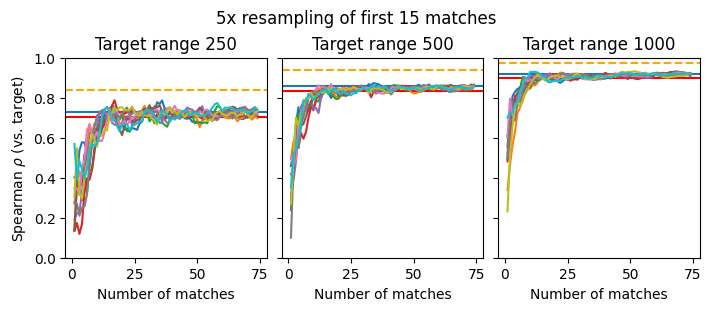

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for (target_range, resampled), ax in zip(resample_fictive.items(), axs):
    ax.set_title(f'Target range {target_range}')
    ax.set_xlabel('Number of matches')

    ax.axhline(np.mean([stats.spearmanr(eshuf.target, eshuf[eshuf.N.max()]).statistic for eshuf in resampled]))
    ax.axhline(stats.spearmanr(range_elo[target_range][0][match_limit], range_elo[target_range][0].target).statistic, color='r')
    ax.axhline(stats.spearmanr(range_elo[target_range][0][matches], range_elo[target_range][0].target).statistic, ls='--', color='orange')

    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning, message='An input array is constant; the correlation coefficient is not defined.')
        for i, eshuf in enumerate(resampled):
            corr = np.full(5*match_limit, np.nan)
            merged = pd.merge(eshuf, range_elo[target_range][0], left_index=True, right_index=True, suffixes=['_shuffled', '_fictive'])
            for n in range(5*match_limit):
                corr[n] = stats.spearmanr(merged[f'{n}_shuffled'], merged.target_shuffled).statistic
            ax.plot(corr)
axs[0].set_ylabel('Spearman $\\rho$ (vs. target)')
axs[0].set_ylim(0, 1)
fig.suptitle(f'5x resampling of first {match_limit} matches');

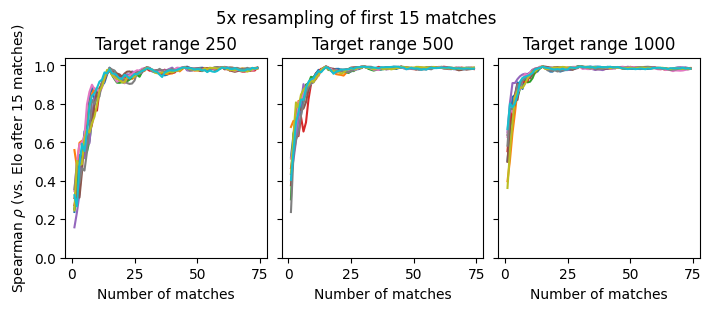

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for (target_range, resampled), ax in zip(resample_fictive.items(), axs):
    ax.set_title(f'Target range {target_range}')
    ax.set_xlabel('Number of matches')

    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning, message='An input array is constant; the correlation coefficient is not defined.')
        for i, eshuf in enumerate(resampled):
            corr = np.full(5*match_limit, np.nan)
            merged = pd.merge(eshuf, range_elo[target_range][0], left_index=True, right_index=True, suffixes=['_shuffled', '_fictive'])
            for n in range(5*match_limit):
                corr[n] = stats.spearmanr(merged[f'{n}_shuffled'], merged[f'{match_limit}_fictive']).statistic
            ax.plot(corr)
axs[0].set_ylabel(f'Spearman $\\rho$ (vs. Elo after {match_limit} matches)')
axs[0].set_ylim(0, None)
fig.suptitle(f'5x resampling of first {match_limit} matches');

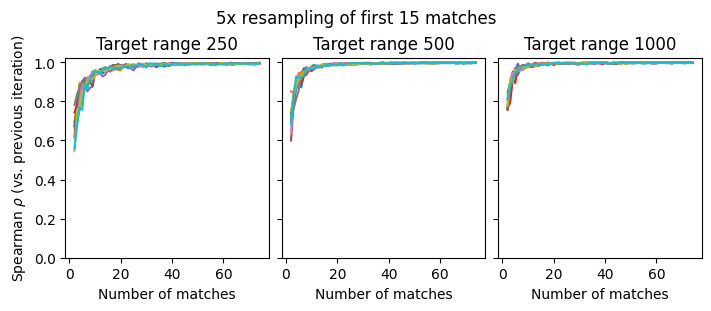

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for (target_range, resampled), ax in zip(resample_fictive.items(), axs):
    ax.set_title(f'Target range {target_range}')
    ax.set_xlabel('Number of matches')

    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning, message='An input array is constant; the correlation coefficient is not defined.')
        for i, eshuf in enumerate(resampled):
            corr = np.full(5*match_limit, np.nan)
            for n in range(1, 5*match_limit):
                corr[n] = stats.spearmanr(eshuf[n-1], eshuf[n]).statistic
            ax.plot(corr)
axs[0].set_ylabel(f'Spearman $\\rho$ (vs. previous iteration)')
axs[0].set_ylim(0, None)
fig.suptitle(f'5x resampling of first {match_limit} matches');

In [16]:
for target_range, resampled in resample_fictive.items():
    corr = []
    for eshuf in resampled:
        merged = pd.merge(eshuf, range_elo[target_range][0], left_index=True, right_index=True, suffixes=['_shuffled', '_fictive'])
        corr.append(stats.spearmanr(merged[f'{match_limit}_fictive'], merged[f'{5*match_limit}_shuffled']).statistic)
    print(target_range, f'{np.mean(corr):.2f} +- {np.std(corr):.2g}')

250 0.99 +- 0.0012
500 0.99 +- 0.0014
1000 0.98 +- 0.0013


In [81]:
n = 40
half = n//2
matches = 100
nrange_elo = {}
nrange_winners = {}
nrange_losers = {}
for target_range in (250, 500, 1000):
    nrange_elo[target_range] = []
    nrange_winners[target_range] = []
    nrange_losers[target_range] = []
    for _ in range(10):
        elo_list = [pd.Series(np.full(n, 1600, int))]
        winner_list, loser_list = [], []
        target_elo = np.random.normal(1600, target_range//2, n).astype(int)
        for i in range(matches):
            candidates = np.random.choice(n, n, replace=False)
            odds = elo_odds(target_elo[candidates[:half]], target_elo[candidates[half:]])
            dice = np.random.uniform(size=half)
            outcomes = odds > dice
            winners = np.where(outcomes, candidates[:half], candidates[half:])
            losers = np.where(outcomes, candidates[half:], candidates[:half])
            winner_elo, loser_elo = elo_match(elo_list[-1][winners].values, elo_list[-1][losers].values, k=16)
            sorted_elo = pd.Series(np.empty(n, int))
            sorted_elo.loc[winners] = winner_elo
            sorted_elo.loc[losers] = loser_elo
            elo_list.append(sorted_elo)
            winner_list.append(winners)
            loser_list.append(losers)
        nrange_elo[target_range].append(pd.DataFrame({'target': target_elo}).join(pd.concat(elo_list, axis=1)))
        nrange_winners[target_range].append(np.concatenate(winner_list))
        nrange_losers[target_range].append(np.concatenate(loser_list))

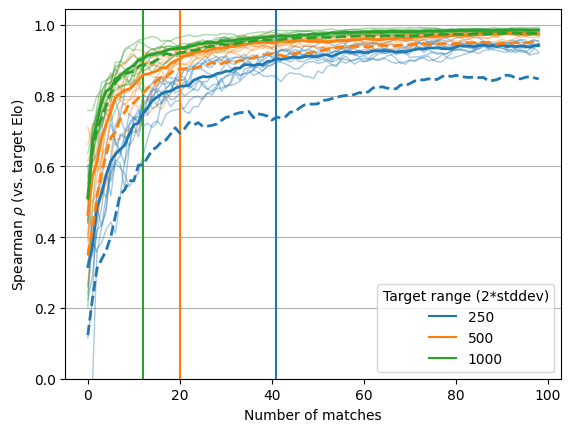

In [184]:
for i, (target_range, sim_elo) in enumerate(nrange_elo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    corrs = []
    for eshuf in sim_elo:
        corr = np.empty(eshuf.columns[-1]-1)
        for m in range(eshuf.columns[-1]-1):
            corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
        plt.plot(corr, c=f'C{i}', alpha=.4, lw=1)
        corrs.append(corr)
    corrs = np.mean(corrs, axis=0)
    plt.plot(corrs, c=f'C{i}', lw=2, zorder=10)
    if (corrs > indicator).sum():
        plt.axvline(np.argmax(corrs > indicator), c=f'C{i}')

    corrs = []
    for eshuf in range_elo[target_range]:
        corr = np.empty(eshuf.columns[-1]-1)
        for m in range(eshuf.columns[-1]-1):
            corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
        corrs.append(corr)
    plt.plot(np.mean(corrs, axis=0), c=f'C{i}', lw=2, zorder=10, ls='--')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend(title='Target range (2*stddev)')

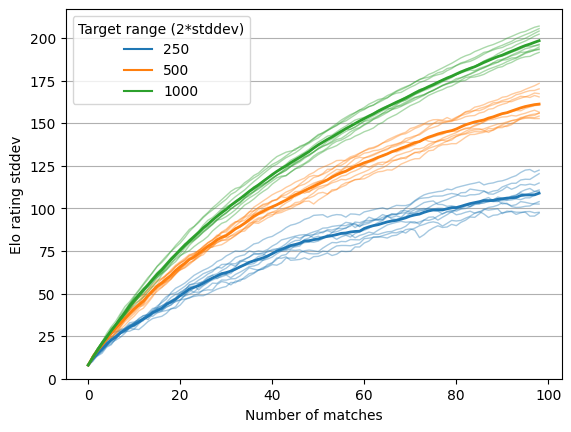

In [185]:
for i, (target_range, sim_elo) in enumerate(nrange_elo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    stds = []
    for eshuf in sim_elo:
        std = np.empty(eshuf.columns[-1]-1)
        for m in range(eshuf.columns[-1]-1):
            std[m] = np.std(eshuf[m+1])
        plt.plot(std, c=f'C{i}', alpha=.4, lw=1)
        stds.append(std)
    stds = np.mean(stds, axis=0)
    plt.plot(stds, c=f'C{i}', lw=2, zorder=10)

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Elo rating stddev')
plt.ylim(0, None)
plt.legend(title='Target range (2*stddev)')

In [20]:
match_limit = 15
resample_nfictive = {}
for target_range, sim_elo in nrange_elo.items():
    fictive = pd.DataFrame({'Item': 0, 'Type': 'mydim', 'Winner': nrange_winners[target_range][0][:match_limit*half], 'Loser': nrange_losers[target_range][0][:match_limit*half]})
    resample_nfictive[target_range] = [
        pd.merge(
            get_ratings(pd.concat([fictive.loc[np.random.choice(len(fictive), len(fictive), replace=False)] for i in range(5)]), dims=['mydim'])['mydim'],
            sim_elo[0]['target'], left_index=True, right_index=True)
        for _ in range(10)]

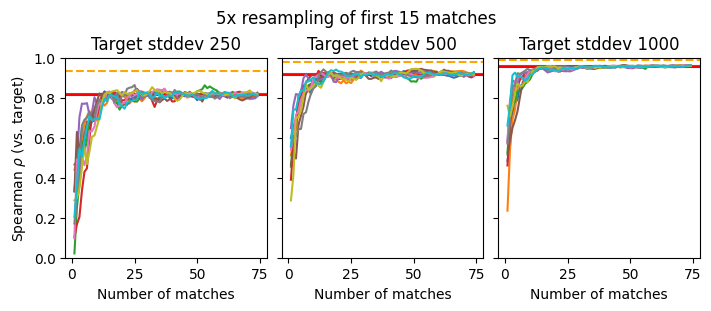

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for (target_range, resampled), ax in zip(resample_nfictive.items(), axs):
    ax.set_title(f'Target stddev {target_range}')
    ax.set_xlabel('Number of matches')
    ax.axhline(np.mean([stats.spearmanr(eshuf.target, eshuf[eshuf.N.max()]).statistic for eshuf in resampled]))
    ax.axhline(stats.spearmanr(nrange_elo[target_range][0][match_limit], nrange_elo[target_range][0].target).statistic, color='r')
    ax.axhline(stats.spearmanr(nrange_elo[target_range][0][matches], nrange_elo[target_range][0].target).statistic, ls='--', color='orange')

    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning, message='An input array is constant; the correlation coefficient is not defined.')
        for i, eshuf in enumerate(resampled):
            corr = np.full(5*match_limit, np.nan)
            merged = pd.merge(eshuf, nrange_elo[target_range][0], left_index=True, right_index=True, suffixes=['_shuffled', '_fictive'])
            for n in range(5*match_limit):
                corr[n] = stats.spearmanr(merged[f'{n}_shuffled'], merged.target_shuffled).statistic
            ax.plot(corr)
axs[0].set_ylabel('Spearman $\\rho$ (vs. target)')
axs[0].set_ylim(0, 1)
fig.suptitle(f'5x resampling of first {match_limit} matches');

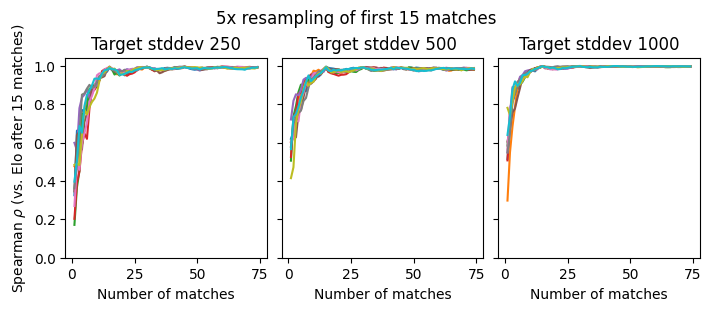

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for (target_range, resampled), ax in zip(resample_nfictive.items(), axs):
    ax.set_title(f'Target stddev {target_range}')
    ax.set_xlabel('Number of matches')

    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning, message='An input array is constant; the correlation coefficient is not defined.')
        for i, eshuf in enumerate(resampled):
            corr = np.full(5*match_limit, np.nan)
            merged = pd.merge(eshuf, nrange_elo[target_range][0], left_index=True, right_index=True, suffixes=['_shuffled', '_fictive'])
            for n in range(5*match_limit):
                corr[n] = stats.spearmanr(merged[f'{n}_shuffled'], merged[f'{match_limit}_fictive']).statistic
            ax.plot(corr)
axs[0].set_ylabel(f'Spearman $\\rho$ (vs. Elo after {match_limit} matches)')
axs[0].set_ylim(0, None)
fig.suptitle(f'5x resampling of first {match_limit} matches');

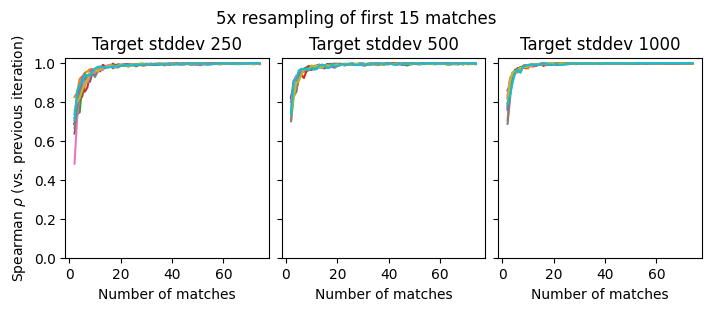

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for (target_range, resampled), ax in zip(resample_nfictive.items(), axs):
    ax.set_title(f'Target stddev {target_range}')
    ax.set_xlabel('Number of matches')

    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning, message='An input array is constant; the correlation coefficient is not defined.')
        for i, eshuf in enumerate(resampled):
            corr = np.full(5*match_limit, np.nan)
            for n in range(1, 5*match_limit):
                corr[n] = stats.spearmanr(eshuf[n-1], eshuf[n]).statistic
            ax.plot(corr)
axs[0].set_ylabel(f'Spearman $\\rho$ (vs. previous iteration)')
axs[0].set_ylim(0, None)
fig.suptitle(f'5x resampling of first {match_limit} matches');

In [24]:
for target_range, resampled in resample_nfictive.items():
    corr = []
    for eshuf in resampled:
        merged = pd.merge(eshuf, nrange_elo[target_range][0], left_index=True, right_index=True, suffixes=['_shuffled', '_fictive'])
        corr.append(stats.spearmanr(merged[f'{match_limit}_fictive'], merged[f'{5*match_limit}_shuffled']).statistic)
    print(target_range, f'{np.mean(corr):.2f} +- {np.std(corr):.2g}')

250 0.99 +- 0.0009
500 0.98 +- 0.0011
1000 1.00 +- 0.00041


# Biasing for close ranks

In [25]:
n = 40
half = n//2
rounds = 100
large_number = 999_999_999
target_range = 250
bias_elo = []
for _ in range(10):
    elo_list = [pd.Series(np.full(n, 1600, int))]
    target_elo = np.random.choice(target_range, n, replace=True) + 1600 - target_range//2
    for i in range(rounds):
        elo = elo_list[-1]
        
        # Make matches based on closest ratings
        diff = np.abs([[elo[i]-elo[j] if j>i else large_number for j in range(n)] for i in range(n)])
        matches = []
        for _ in range(half):
            a,b = np.unravel_index(diff.argmin(), diff.shape)
            matches.append([a,b])
            diff[a, :] = diff[:, a] = diff[b, :] = diff[:, b] = large_number
        matches = np.asarray(matches)

        # Decide match outcomes
        odds = elo_odds(target_elo[matches[:, 0]], target_elo[matches[:, 1]])
        dice = np.random.uniform(size=len(odds))
        outcomes = odds > dice
        winners = np.where(outcomes, matches[:, 0], matches[:, 1])
        losers = np.where(outcomes, matches[:, 1], matches[:, 0])

        # Update ratings
        winner_elo, loser_elo = elo_match(elo[winners].values, elo[losers].values, k=16)
        sorted_elo = elo.copy()
        sorted_elo.loc[winners] = winner_elo
        sorted_elo.loc[losers] = loser_elo
        elo_list.append(sorted_elo)

    bias_elo.append(pd.DataFrame({'target': target_elo}).join(pd.concat(elo_list, axis=1)))

Text(0.5, 1.0, 'Rank proximity bias (full rounds, uniform distribution, target range 250)')

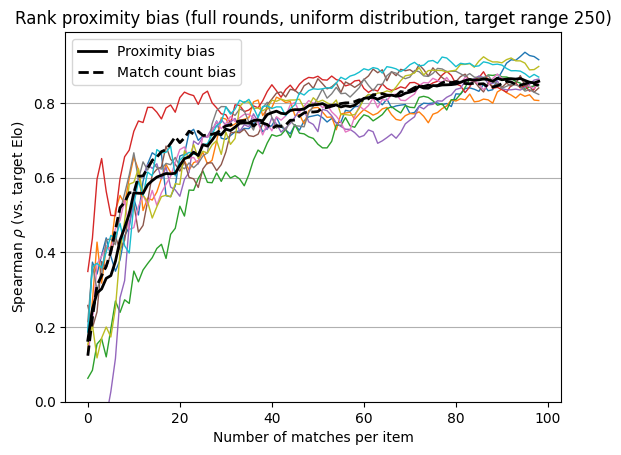

In [26]:
corrs = []
for eshuf in bias_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    plt.plot(np.arange(len(corr)), corr, lw=1)
    corrs.append(corr)
plt.plot(np.arange(len(corr)), np.mean(corrs, axis=0), c='k', lw=2, zorder=10, label='Proximity bias')

corrs = []
for eshuf in range_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, ls='--', zorder=10, label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches per item')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title(f'Rank proximity bias (full rounds, uniform distribution, target range {target_range})')

In [27]:
n = 40
half = n//2
quarter = half//4
rounds = 400
large_number = 999_999_999
target_range = 250
bias_short_elo = []
for _ in range(10):
    elo_list = [pd.Series(np.full(n, 1600, int))]
    num_matches = np.zeros(n, int)
    weights_list = [num_matches.copy()]
    nth_list = []
    target_elo = np.random.choice(target_range, n, replace=True) + 1600 - target_range//2
    for iround in range(rounds):
        elo = elo_list[-1]
        
        # Make matches based on closest ratings
        diff = np.abs([[elo[i]-elo[j] if j>i else large_number for j in range(n)] for i in range(n)])
        matches = []
        for _ in range(quarter):
            a,b = np.unravel_index(diff.argmin(), diff.shape)
            matches.append([a,b])
            diff[a, :] = diff[:, a] = diff[b, :] = diff[:, b] = large_number
        matches = np.asarray(matches)

        # Decide match outcomes
        odds = elo_odds(target_elo[matches[:, 0]], target_elo[matches[:, 1]])
        dice = np.random.uniform(size=len(odds))
        outcomes = odds > dice
        winners = np.where(outcomes, matches[:, 0], matches[:, 1])
        losers = np.where(outcomes, matches[:, 1], matches[:, 0])

        # Update ratings
        winner_elo, loser_elo = elo_match(elo[winners].values, elo[losers].values, k=16)
        sorted_elo = elo.copy()
        sorted_elo.loc[winners] = winner_elo
        sorted_elo.loc[losers] = loser_elo
        elo_list.append(sorted_elo)

        # Update left-aligned ratings
        for winner, w_elo in zip(winners, winner_elo):
            if num_matches[winner] >= len(nth_list):
                nth_list.append(np.full(n, large_number, dtype=int))
            nth_list[num_matches[winner]][winner] = w_elo
        for loser, l_elo in zip(losers, loser_elo):
            if num_matches[loser] >= len(nth_list):
                nth_list.append(np.full(n, large_number, dtype=int))
            nth_list[num_matches[loser]][loser] = l_elo

        # Update match count and weights
        num_matches[winners] += 1
        num_matches[losers] += 1
        weights_list.append(num_matches.copy())
    
    for i, nth in enumerate(nth_list):
        mask = nth==large_number
        nth[mask] = nth_list[i-1][mask]

    bias_short_elo.append(
        pd.DataFrame({'target': target_elo, 'num_matches': num_matches})
        .join(pd.concat(elo_list, axis=1))
        .join(pd.DataFrame({f'w_{i}': w for i, w in enumerate(weights_list)}))
        .join(pd.DataFrame({f'la_{i}': nth for i, nth in enumerate(nth_list)})))

Text(0.5, 1.0, 'Rank proximity bias (1/4 rounds, uniform distribution, target range 250)')

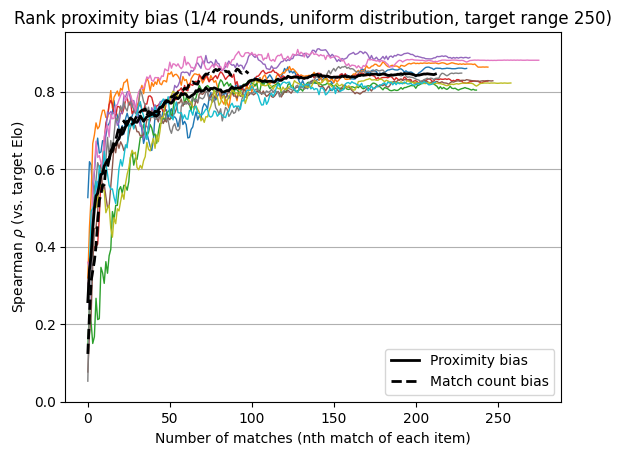

In [28]:
corrs = []
for eshuf in bias_short_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        if f'la_{m+1}' in eshuf:
            corr[m] = stats.spearmanr(eshuf[f'la_{m+1}'], eshuf['target']).statistic
        else:
            corr[m] = np.nan
    plt.plot(corr, lw=1)
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, zorder=10, label='Proximity bias')

corrs = []
for eshuf in range_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, ls='--', zorder=10, label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches (nth match of each item)')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title(f'Rank proximity bias (1/4 rounds, uniform distribution, target range {target_range})')

Text(0.5, 1.0, 'Rank proximity bias (1/4 rounds, uniform distribution, target range 250)')

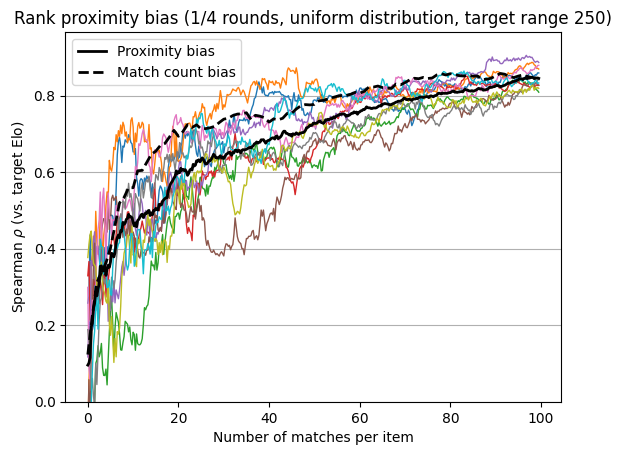

In [29]:
corrs = []
for eshuf in bias_short_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    plt.plot(np.arange(len(corr))/4, corr, lw=1)
    corrs.append(corr)
plt.plot(np.arange(len(corr))/4, np.mean(corrs, axis=0), c='k', lw=2, zorder=10, label='Proximity bias')

corrs = []
for eshuf in range_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, ls='--', zorder=10, label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches per item')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title(f'Rank proximity bias (1/4 rounds, uniform distribution, target range {target_range})')

Text(0.5, 1.0, 'Rank proximity bias: Match count (uniform distribution)')

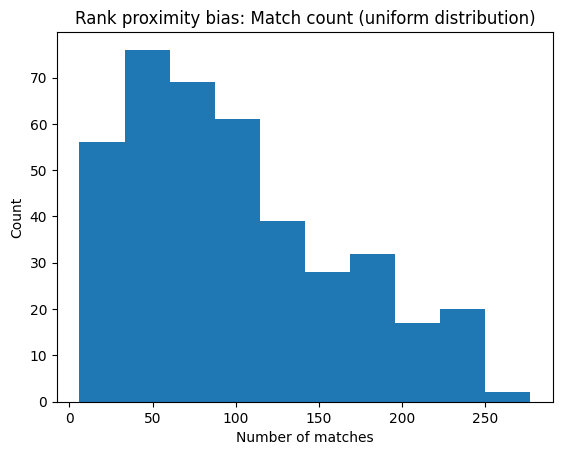

In [30]:
plt.hist([n for eshuf in bias_short_elo for n in eshuf.num_matches])
plt.xlabel('Number of matches')
plt.ylabel('Count')
plt.title('Rank proximity bias: Match count (uniform distribution)')

In [31]:
n = 40
half = n//2
rounds = 100
large_number = 999_999_999
target_range = 250
nbias_elo = []
for _ in range(10):
    elo_list = [pd.Series(np.full(n, 1600, int))]
    target_elo = np.random.normal(1600, target_range//2, n).astype(int)
    for i in range(rounds):
        elo = elo_list[-1]
        
        # Make matches based on closest ratings
        diff = np.abs([[elo[i]-elo[j] if j>i else large_number for j in range(n)] for i in range(n)])
        matches = []
        for _ in range(half):
            a,b = np.unravel_index(diff.argmin(), diff.shape)
            matches.append([a,b])
            diff[a, :] = diff[:, a] = diff[b, :] = diff[:, b] = large_number
        matches = np.asarray(matches)

        # Decide match outcomes
        odds = elo_odds(target_elo[matches[:, 0]], target_elo[matches[:, 1]])
        dice = np.random.uniform(size=len(odds))
        outcomes = odds > dice
        winners = np.where(outcomes, matches[:, 0], matches[:, 1])
        losers = np.where(outcomes, matches[:, 1], matches[:, 0])

        # Update ratings
        winner_elo, loser_elo = elo_match(elo[winners].values, elo[losers].values, k=16)
        sorted_elo = elo.copy()
        sorted_elo.loc[winners] = winner_elo
        sorted_elo.loc[losers] = loser_elo
        elo_list.append(sorted_elo)

    nbias_elo.append(pd.DataFrame({'target': target_elo}).join(pd.concat(elo_list, axis=1)))

Text(0.5, 1.0, 'Rank proximity bias (full rounds, normal distribution)')

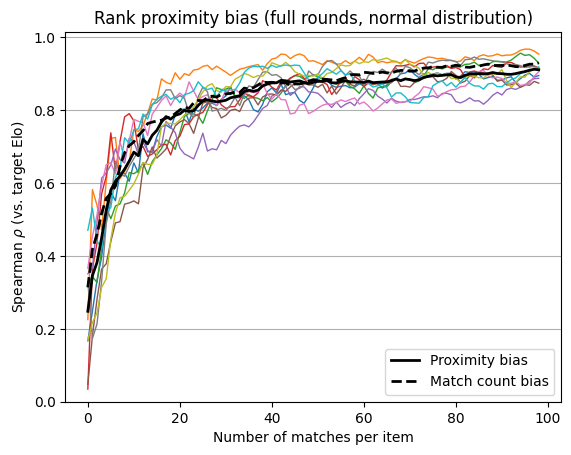

In [32]:
corrs = []
for eshuf in nbias_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    plt.plot(np.arange(len(corr)), corr, lw=1)
    corrs.append(corr)
plt.plot(np.arange(len(corr)), np.mean(corrs, axis=0), c='k', lw=2, zorder=10, label='Proximity bias')

corrs = []
for eshuf in nrange_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, ls='--', zorder=10, label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches per item')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title('Rank proximity bias (full rounds, normal distribution)')

In [33]:
n = 40
half = n//2
quarter = half//4
rounds = 400
large_number = 999_999_999
target_range = 250
nbias_short_elo = []
for _ in range(10):
    elo_list = [pd.Series(np.full(n, 1600, int))]
    num_matches = np.zeros(n, int)
    weights_list = [num_matches.copy()]
    nth_list = []
    target_elo = np.random.normal(1600, target_range//2, n).astype(int)
    for i in range(rounds):
        elo = elo_list[-1]
        
        # Make matches based on closest ratings
        diff = np.abs([[elo[i]-elo[j] if j>i else large_number for j in range(n)] for i in range(n)])
        matches = []
        for _ in range(quarter):
            a,b = np.unravel_index(diff.argmin(), diff.shape)
            matches.append([a,b])
            diff[a, :] = diff[:, a] = diff[b, :] = diff[:, b] = large_number
        matches = np.asarray(matches)

        # Decide match outcomes
        odds = elo_odds(target_elo[matches[:, 0]], target_elo[matches[:, 1]])
        dice = np.random.uniform(size=len(odds))
        outcomes = odds > dice
        winners = np.where(outcomes, matches[:, 0], matches[:, 1])
        losers = np.where(outcomes, matches[:, 1], matches[:, 0])

        # Update ratings
        winner_elo, loser_elo = elo_match(elo[winners].values, elo[losers].values, k=16)
        sorted_elo = elo.copy()
        sorted_elo.loc[winners] = winner_elo
        sorted_elo.loc[losers] = loser_elo
        elo_list.append(sorted_elo)

        # Update left-aligned ratings
        for winner, w_elo in zip(winners, winner_elo):
            if num_matches[winner] >= len(nth_list):
                nth_list.append(np.full(n, large_number, dtype=int))
            nth_list[num_matches[winner]][winner] = w_elo
        for loser, l_elo in zip(losers, loser_elo):
            if num_matches[loser] >= len(nth_list):
                nth_list.append(np.full(n, large_number, dtype=int))
            nth_list[num_matches[loser]][loser] = l_elo

        # Update match count and weights
        num_matches[winners] += 1
        num_matches[losers] += 1
        weights_list.append(num_matches.copy())
    
    for i, nth in enumerate(nth_list):
        mask = nth==large_number
        nth[mask] = nth_list[i-1][mask]

    nbias_short_elo.append(
        pd.DataFrame({'target': target_elo, 'num_matches': num_matches})
        .join(pd.concat(elo_list, axis=1))
        .join(pd.DataFrame({f'w_{i}': w for i, w in enumerate(weights_list)}))
        .join(pd.DataFrame({f'la_{i}': nth for i, nth in enumerate(nth_list)})))

Text(0.5, 1.0, 'Rank proximity bias (1/4 rounds, normal distribution)')

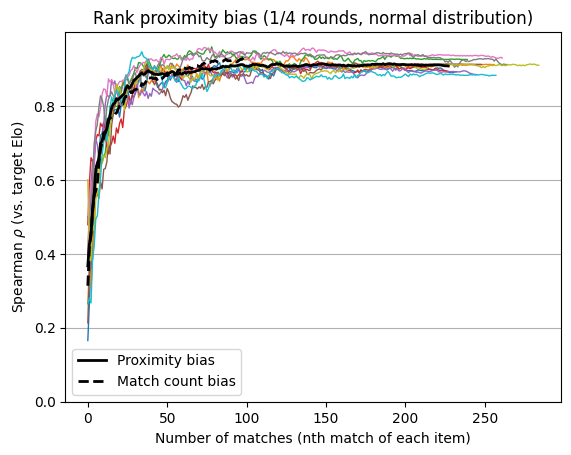

In [34]:
corrs = []
for eshuf in nbias_short_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        if f'la_{m+1}' in eshuf:
            corr[m] = stats.spearmanr(eshuf[f'la_{m+1}'], eshuf['target']).statistic
        else:
            corr[m] = np.nan
    plt.plot(corr, lw=1)
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, zorder=10, label='Proximity bias')

corrs = []
for eshuf in nrange_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, ls='--', zorder=10, label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches (nth match of each item)')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title(f'Rank proximity bias (1/4 rounds, normal distribution)')

Text(0.5, 1.0, 'Rank proximity bias (1/4 rounds, normal distribution)')

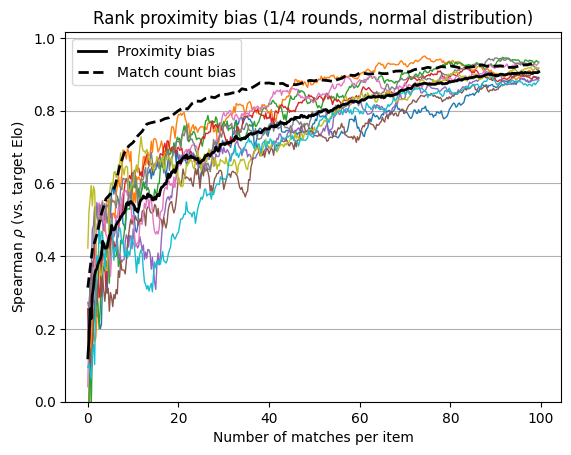

In [35]:
corrs = []
for eshuf in nbias_short_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    plt.plot(np.arange(len(corr))/4, corr, lw=1)
    corrs.append(corr)
plt.plot(np.arange(len(corr))/4, np.mean(corrs, axis=0), c='k', lw=2, zorder=10, label='Proximity bias')

corrs = []
for eshuf in nrange_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, ls='--', zorder=10, label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches per item')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title('Rank proximity bias (1/4 rounds, normal distribution)')

Text(0.5, 1.0, 'Rank proximity bias: Match count (normal distribution)')

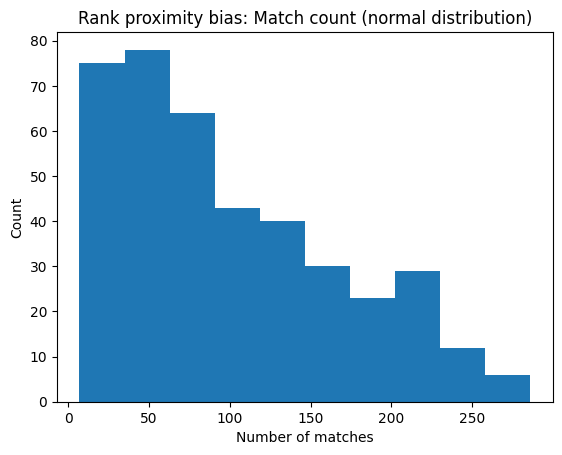

In [36]:
plt.hist([n for eshuf in nbias_short_elo for n in eshuf.num_matches])
plt.xlabel('Number of matches')
plt.ylabel('Count')
plt.title('Rank proximity bias: Match count (normal distribution)')

## Biasing with random choice

In [37]:
n = 40
half = n//2
quarter = half//4
rounds = 400
large_number = 999_999_999
target_range = 250
rand_bias_short_elo = []
for _ in range(10):
    elo_list = [pd.Series(np.full(n, 1600, int))]
    num_matches = np.zeros(n, int)
    weights_list = [num_matches.copy()]
    target_elo = np.random.choice(target_range, n, replace=True) + 1600 - target_range//2
    for i in range(rounds):
        elo = elo_list[-1]
        
        # Make matches based on closest ratings
        diff = np.abs([[elo[i]-elo[j] if j>i else large_number for j in range(n)] for i in range(n)])
        matches = []
        for _ in range(quarter):
            a,b = np.where(diff == diff.min())
            nth = np.random.choice(len(a))
            a,b = a[nth], b[nth]
            matches.append([a,b])
            diff[a, :] = diff[:, a] = diff[b, :] = diff[:, b] = large_number
        matches = np.asarray(matches)

        # Decide match outcomes
        odds = elo_odds(target_elo[matches[:, 0]], target_elo[matches[:, 1]])
        dice = np.random.uniform(size=len(odds))
        outcomes = odds > dice
        winners = np.where(outcomes, matches[:, 0], matches[:, 1])
        losers = np.where(outcomes, matches[:, 1], matches[:, 0])

        # Update ratings
        winner_elo, loser_elo = elo_match(elo[winners].values, elo[losers].values, k=16)
        sorted_elo = elo.copy()
        sorted_elo.loc[winners] = winner_elo
        sorted_elo.loc[losers] = loser_elo
        elo_list.append(sorted_elo)

        num_matches[winners] += 1
        num_matches[losers] += 1
        weights_list.append(num_matches.copy())

    rand_bias_short_elo.append(pd.DataFrame({'target': target_elo, 'num_matches': num_matches}).join(pd.concat(elo_list, axis=1)).join(pd.DataFrame({f'w_{i}': w for i, w in enumerate(weights_list)})))

Text(0.5, 1.0, 'Rank proximity bias (1/4 rounds, uniform distribution)')

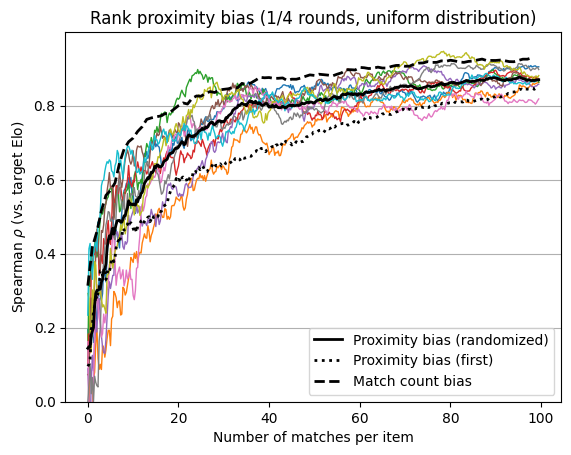

In [38]:
corrs = []
for eshuf in rand_bias_short_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    plt.plot(np.arange(len(corr))/4, corr, lw=1)
    corrs.append(corr)
plt.plot(np.arange(len(corr))/4, np.mean(corrs, axis=0), c='k', lw=2, zorder=10, label='Proximity bias (randomized)')

corrs = []
for eshuf in bias_short_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.arange(len(corr))/4, np.mean(corrs, axis=0), c='k', lw=2, ls=':', zorder=10, label='Proximity bias (first)')

corrs = []
for eshuf in nrange_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, ls='--', zorder=10, label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches per item')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title('Rank proximity bias (1/4 rounds, uniform distribution)')

Text(0.5, 1.0, 'Rank proximity bias (randomized): Match count (normal distribution)')

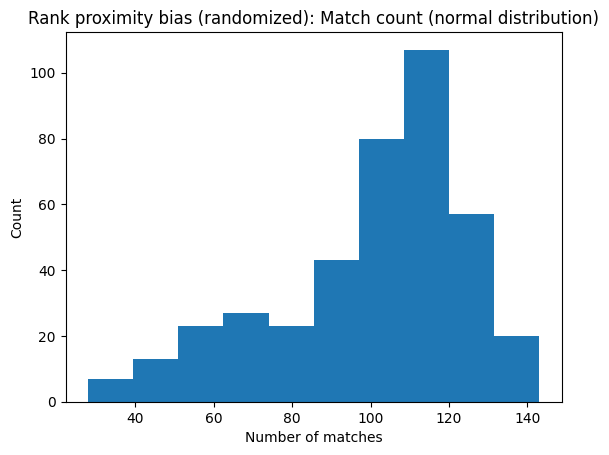

In [39]:
plt.hist([n for eshuf in rand_bias_short_elo for n in eshuf.num_matches])
plt.xlabel('Number of matches')
plt.ylabel('Count')
plt.title('Rank proximity bias (randomized): Match count (normal distribution)')

In [40]:
n = 40
half = n//2
quarter = half//4
rounds = 400
large_number = 999_999_999
target_range = 250
nrand_bias_short_elo = []
for _ in range(10):
    elo_list = [pd.Series(np.full(n, 1600, int))]
    num_matches = np.zeros(n, int)
    weights_list = [num_matches.copy()]
    target_elo = np.random.normal(1600, target_range//2, n).astype(int)
    for i in range(rounds):
        elo = elo_list[-1]
        
        # Make matches based on closest ratings
        diff = np.abs([[elo[i]-elo[j] if j>i else large_number for j in range(n)] for i in range(n)])
        matches = []
        for _ in range(quarter):
            a,b = np.where(diff == diff.min())
            nth = np.random.choice(len(a))
            a,b = a[nth], b[nth]
            matches.append([a,b])
            diff[a, :] = diff[:, a] = diff[b, :] = diff[:, b] = large_number
        matches = np.asarray(matches)

        # Decide match outcomes
        odds = elo_odds(target_elo[matches[:, 0]], target_elo[matches[:, 1]])
        dice = np.random.uniform(size=len(odds))
        outcomes = odds > dice
        winners = np.where(outcomes, matches[:, 0], matches[:, 1])
        losers = np.where(outcomes, matches[:, 1], matches[:, 0])

        # Update ratings
        winner_elo, loser_elo = elo_match(elo[winners].values, elo[losers].values, k=16)
        sorted_elo = elo.copy()
        sorted_elo.loc[winners] = winner_elo
        sorted_elo.loc[losers] = loser_elo
        elo_list.append(sorted_elo)

        num_matches[winners] += 1
        num_matches[losers] += 1
        weights_list.append(num_matches.copy())

    nrand_bias_short_elo.append(pd.DataFrame({'target': target_elo, 'num_matches': num_matches}).join(pd.concat(elo_list, axis=1)).join(pd.DataFrame({f'w_{i}': w for i, w in enumerate(weights_list)})))

Text(0.5, 1.0, 'Rank proximity bias (1/4 rounds, normal distribution)')

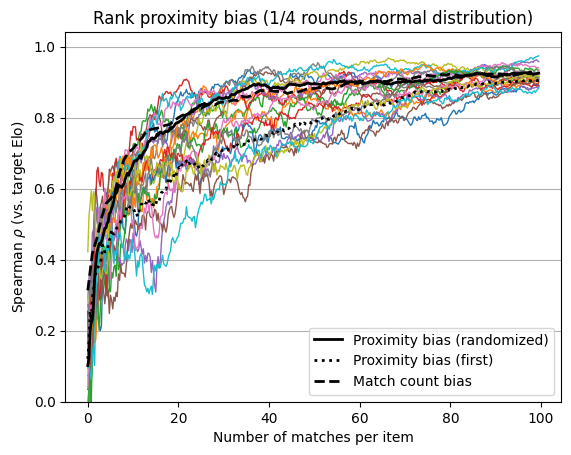

In [41]:
corrs = []
for eshuf in nrand_bias_short_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    plt.plot(np.arange(len(corr))/4, corr, lw=1)
    corrs.append(corr)
plt.plot(np.arange(len(corr))/4, np.mean(corrs, axis=0), c='k', lw=2, zorder=10, label='Proximity bias (randomized)')

corrs = []
for eshuf in nbias_short_elo:
    corr = np.empty(rounds-1)
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    plt.plot(np.arange(len(corr))/4, corr, lw=1)
    corrs.append(corr)
plt.plot(np.arange(len(corr))/4, np.mean(corrs, axis=0), c='k', lw=2, ls=':', zorder=10, label='Proximity bias (first)')

corrs = []
for eshuf in nrange_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), c='k', lw=2, ls='--', zorder=10, label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches per item')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title('Rank proximity bias (1/4 rounds, normal distribution)')

Text(0.5, 1.0, 'Rank proximity bias (randomized): Match count (normal distribution)')

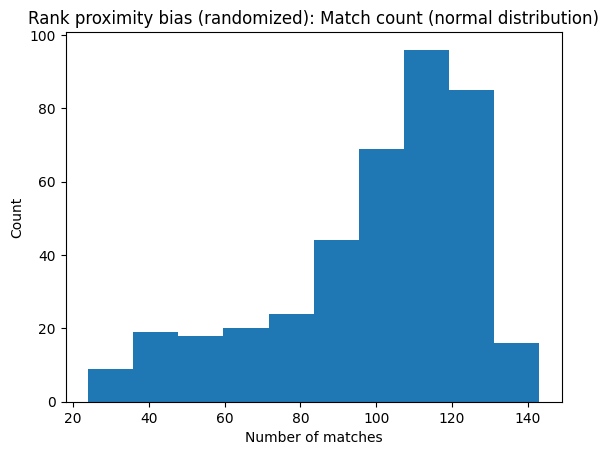

In [42]:
plt.hist([n for eshuf in nrand_bias_short_elo for n in eshuf.num_matches])
plt.xlabel('Number of matches')
plt.ylabel('Count')
plt.title('Rank proximity bias (randomized): Match count (normal distribution)')

# On weighted correlation

In [5]:
def weighted_spearmanr(a, b, w):
    # Weighted Spearman's rho, see https://doi.org/10.1007/978-3-319-00032-9_13 eq. 4
    a,b,w = map(np.asarray, (a,b,w))  # Boilerplate
    ra, rb = map(stats.rankdata, (a,b))  # Turn scores a,b into ranks ra,rb, resolving ties by method
            # 'average' := The average of the ranks that would have been assigned to 
            # all the tied values is assigned to each value.
    wmean_ra, wsum = np.average(ra, weights=w, returned=True)  # Weighted average and sum-of-weights
    wmean_rb = np.average(rb, weights=w)  # Weighted average
    dev_ra = ra - wmean_ra
    dev_rb = rb - wmean_rb
    wstd_ra = np.sqrt(np.average(dev_ra**2, weights=w))  # weighted standard deviation of sample
    wstd_rb = np.sqrt(np.average(dev_rb**2, weights=w))  # i.e., sig_w = root of weighted mean square deviations
    return np.sum(dev_ra * dev_rb * w) / (wstd_ra * wstd_rb * wsum)

Text(0.5, 1.0, 'Impact of weighted correlation\n(rank proximity bias, 1/4 rounds, uniform distribution)')

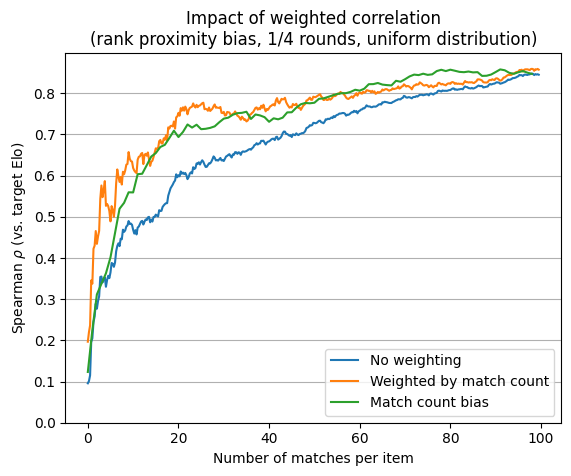

In [44]:
corrs, wcorrs = [], []
for eshuf in bias_short_elo:
    corr, wcorr = np.empty((2,rounds-1))
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf.target).statistic
        wcorr[m] = weighted_spearmanr(eshuf[m+1], eshuf.target, eshuf[f'w_{m+1}'])
    corrs.append(corr)
    wcorrs.append(wcorr)
plt.plot(np.arange(len(corr))/4, np.mean(corrs, axis=0), label='No weighting')
plt.plot(np.arange(len(wcorr))/4, np.mean(wcorrs, axis=0), label='Weighted by match count')

corrs = []
for eshuf in range_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches per item')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title('Impact of weighted correlation\n(rank proximity bias, 1/4 rounds, uniform distribution)')

Text(0.5, 1.0, 'Impact of weighted correlation\n(rank proximity bias, 1/4 rounds, normal distribution)')

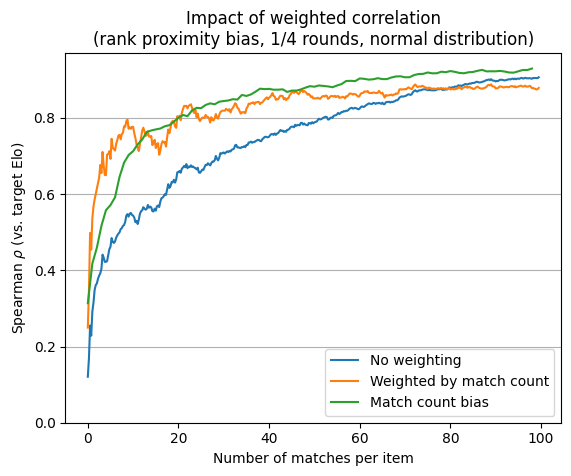

In [45]:
corrs, wcorrs = [], []
for eshuf in nbias_short_elo:
    corr, wcorr = np.empty((2,rounds-1))
    for m in range(rounds-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf.target).statistic
        wcorr[m] = weighted_spearmanr(eshuf[m+1], eshuf.target, eshuf[f'w_{m+1}'])
    corrs.append(corr)
    wcorrs.append(wcorr)
plt.plot(np.arange(len(corr))/4, np.mean(corrs, axis=0), label='No weighting')
plt.plot(np.arange(len(wcorr))/4, np.mean(wcorrs, axis=0), label='Weighted by match count')

corrs = []
for eshuf in nrange_elo[target_range]:
    corr = np.empty(eshuf.columns[-1]-1)
    for m in range(eshuf.columns[-1]-1):
        corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
    corrs.append(corr)
plt.plot(np.mean(corrs, axis=0), label='Match count bias')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches per item')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend()
plt.title('Impact of weighted correlation\n(rank proximity bias, 1/4 rounds, normal distribution)')

# Searching for indicators of ground-truth spread

In [6]:
from scipy.optimize import curve_fit

def exponential_growth(x, a, b):
    return a * (1 - np.exp(-b * x))

def exponential_offset(x, a, b, c):
    return c + a * (1 - np.exp(-b * x))

In [55]:
n = 40
half = n//2
matches = 200
stdindicator_elo = {}
for target_range in (25,50,75,100,125,150,175,200,250,300,400,500):
    stdindicator_elo[target_range] = []
    for _ in range(10):
        elo_list = [pd.Series(np.full(n, 1600, int))]
        target_elo = np.random.normal(1600, target_range, n).astype(int)
        for i in range(matches):
            candidates = np.random.choice(n, n, replace=False)
            odds = elo_odds(target_elo[candidates[:half]], target_elo[candidates[half:]])
            dice = np.random.uniform(size=half)
            outcomes = odds > dice
            winners = np.where(outcomes, candidates[:half], candidates[half:])
            losers = np.where(outcomes, candidates[half:], candidates[:half])
            winner_elo, loser_elo = elo_match(elo_list[-1][winners].values, elo_list[-1][losers].values, k=16)
            sorted_elo = pd.Series(np.empty(n, int))
            sorted_elo.loc[winners] = winner_elo
            sorted_elo.loc[losers] = loser_elo
            elo_list.append(sorted_elo)
        stdindicator_elo[target_range].append(pd.DataFrame({'target': target_elo}).join(pd.concat(elo_list, axis=1)))

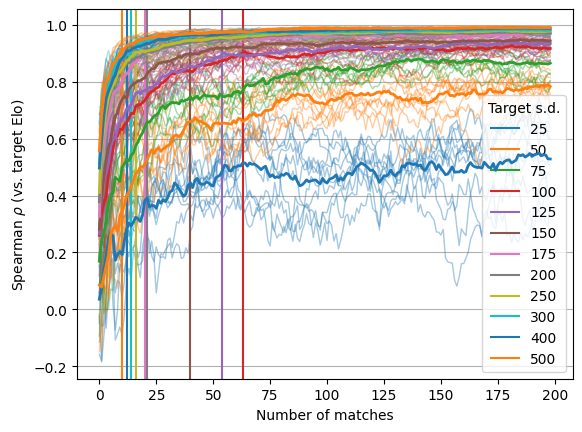

In [208]:
for i, (target_range, sim_elo) in enumerate(stdindicator_elo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    corrs = []
    for eshuf in sim_elo:
        corr = np.empty(eshuf.columns[-1]-1)
        for m in range(eshuf.columns[-1]-1):
            corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
        plt.plot(corr, c=f'C{i}', alpha=.4, lw=1)
        corrs.append(corr)
    corrs = np.mean(corrs, axis=0)
    plt.plot(corrs, c=f'C{i}', lw=2, zorder=10)
    if (corrs > indicator).sum():
        plt.axvline(np.argmax(corrs > indicator), c=f'C{i}')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.legend(title='Target s.d.')

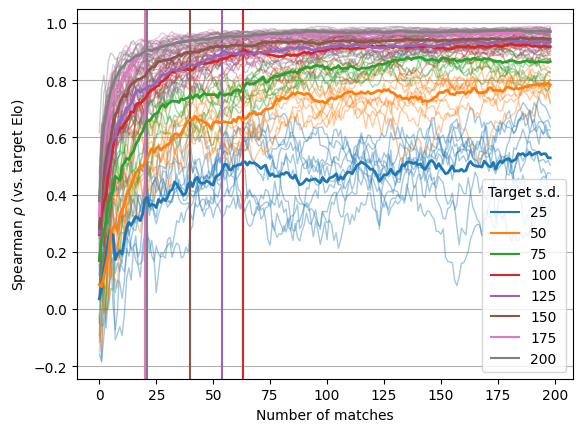

In [218]:
for i, (target_range, sim_elo) in enumerate(stdindicator_elo.items()):
    if target_range > 200:
        continue
    plt.plot([], c=f'C{i}', label=target_range)
    corrs = []
    for eshuf in sim_elo:
        corr = np.empty(eshuf.columns[-1]-1)
        for m in range(eshuf.columns[-1]-1):
            corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
        plt.plot(corr, c=f'C{i}', alpha=.4, lw=1)
        corrs.append(corr)
    corrs = np.mean(corrs, axis=0)
    plt.plot(corrs, c=f'C{i}', lw=2, zorder=10)
    if (corrs > indicator).sum():
        plt.axvline(np.argmax(corrs > indicator), c=f'C{i}')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.legend(title='Target s.d.')


 25
Exp 49.840950435701465 12.721604955050024
Offset 45.82051620232708 14.14968534251148
	params [35.21851247  0.05545073  8.59545277]

 50
Exp 56.28311549269658 9.253871269020843
Offset 49.52056375610145 10.710528972104262
	params [5.21628599e+01 3.10653384e-02 9.47560049e+00]

 75
Exp 56.93228900509972 10.802903906059727
Offset 43.705077249400475 11.716425589256632
	params [6.83623235e+01 2.11288208e-02 1.21665373e+01]

 100
Exp 55.96749162304553 10.169066062862893
Offset 42.364396816645765 10.173550773460239
	params [1.01567036e+02 1.82793175e-02 1.06910666e+01]

 125
Exp 50.896863207242646 13.718963852200682
Offset 34.038481793806326 6.82779010980248
	params [1.08439863e+02 1.87011324e-02 1.14736336e+01]

 150
Exp 52.442355120940384 12.875832098801848
Offset 33.98029376572049 8.226623289491567
	params [1.32759412e+02 1.57309374e-02 1.21641537e+01]

 175
Exp 55.842002365839335 5.669342678186241
Offset 37.882850888215955 5.921138161228014
	params [1.62695187e+02 1.52093663e-02 1.237

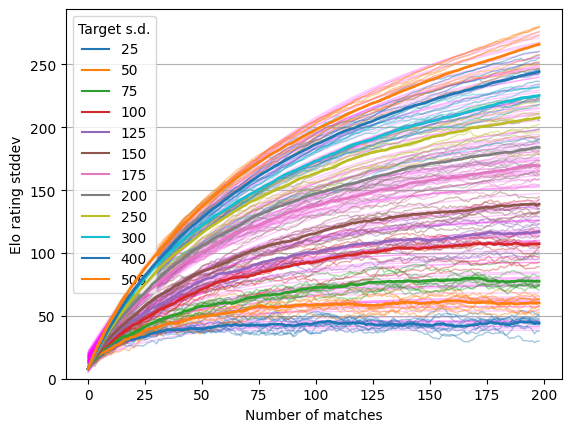

In [209]:
params_long = {}
for i, (target_range, sim_elo) in enumerate(stdindicator_elo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    stds = []
    err_exp, err_offset = [], []
    fit_params = []
    for eshuf in sim_elo:
        M = np.arange(eshuf.columns[-1]-1) + 1
        std = np.empty(M.size)
        for m in M:
            std[m-1] = np.std(eshuf[m])
        plt.plot(std, c=f'C{i}', alpha=.4, lw=1)
        stds.append(std)
        
        params_exp, _ = curve_fit(exponential_growth, M, std, p0=[200, .01], maxfev=10000)
        fit = exponential_growth(M, *params_exp)
        # plt.plot(fit, c='magenta', alpha=.2, lw=1, zorder=-1)
        err_exp.append(np.sqrt(np.sum((fit-std)**2)))

        params_offset, _ = curve_fit(exponential_offset, M, std, p0=[200, .01, 0], maxfev=10000)
        fit = exponential_offset(M, *params_offset)
        plt.plot(fit, c='magenta', alpha=.2, lw=1, zorder=-1)
        err_offset.append(np.sqrt(np.sum((fit-std)**2)))
        fit_params.append(params_offset)

    stds = np.mean(stds, axis=0)
    plt.plot(stds, c=f'C{i}', lw=2, zorder=10)

    print('\n', target_range)
    print('Exp', np.mean(err_exp), np.std(err_exp))
    print('Offset', np.mean(err_offset), np.std(err_offset))
    print('\tparams', np.mean(fit_params, axis=0))
    params_long[target_range] = fit_params

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Elo rating stddev')
plt.ylim(0, None)
plt.legend(title='Target s.d.')


 25
Exp 10.157753708637873 2.5778392021076644
Offset 7.236175531407845 1.2473451067510655
	params [40.0921496   0.08858414  5.61474164]

 50
Exp 13.618231477498977 3.1714867311369686
Offset 7.9996925166285155 1.8423925249970001
	params [9.21570601e+03 4.11189488e-02 8.17189291e+00]

 75
Exp 12.115681045942194 2.4406875975815026
Offset 7.9335328005229515 2.062847490508144
	params [50.03751011  0.05586123  7.15747975]

 100
Exp 12.058358600551516 3.031223037113214
Offset 6.617256048801726 1.4259102162882549
	params [2.14215583e+04 4.10230292e-02 6.98709966e+00]

 125
Exp 11.810632473083349 2.4745049753496815
Offset 7.070634368617364 1.9548800394202281
	params [1.12833981e+02 4.14701460e-02 6.73594374e+00]

 150
Exp 12.218509027512729 1.5151604098364675
Offset 6.6464892300360106 1.3378483793013987
	params [1.29269701e+02 3.02138580e-02 6.89816217e+00]

 175
Exp 9.894138860918051 1.9734447428646056
Offset 6.020878172622702 2.1229019005326872
	params [1.26656298e+02 3.04722738e-02 5.175466

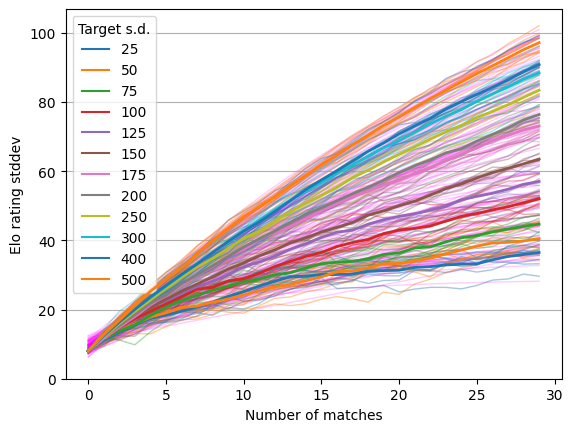

In [210]:
params_short = {}
short_matches = 30
for i, (target_range, sim_elo) in enumerate(stdindicator_elo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    stds = []
    err_exp, err_offset = [], []
    fit_params = []
    for eshuf in sim_elo:
        M = np.arange(short_matches) + 1
        std = np.empty(M.size)
        for m in M:
            std[m-1] = np.std(eshuf[m])
        plt.plot(std, c=f'C{i}', alpha=.4, lw=1)
        stds.append(std)
        
        params_exp, _ = curve_fit(exponential_growth, M, std, p0=[200, .01], maxfev=10000)
        fit = exponential_growth(M, *params_exp)
        # plt.plot(fit, c='magenta', alpha=.2, lw=1, zorder=-1)
        err_exp.append(np.sqrt(np.sum((fit-std)**2)))

        params_offset, _ = curve_fit(exponential_offset, M, std, p0=[200, .01, 0], maxfev=10000)
        fit = exponential_offset(M, *params_offset)
        plt.plot(fit, c='magenta', alpha=.2, lw=1, zorder=-1)
        err_offset.append(np.sqrt(np.sum((fit-std)**2)))
        fit_params.append(params_offset)

    stds = np.mean(stds, axis=0)
    plt.plot(stds, c=f'C{i}', lw=2, zorder=10)

    print('\n', target_range)
    print('Exp', np.mean(err_exp), np.std(err_exp))
    print('Offset', np.mean(err_offset), np.std(err_offset))
    print('\tparams', np.mean(fit_params, axis=0))
    params_short[target_range] = fit_params

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Elo rating stddev')
plt.ylim(0, None)
plt.legend(title='Target s.d.')

0
[ 332.49182332393616,  0.0038473537393172,  -5.520582774372002,  ],
[ -0.09031251149543917,  0.031196718016642727,  0.10378020281416044,  ],
[ 8.79518789306466,  0.003321060539354554,  8.511111991386866,  ],


/tmp/ipykernel_133256/778313603.py:7: RuntimeWarning: overflow encountered in exp
  return c + a * (1 - np.exp(-b * x))


array([[ 3.32491823e+02,  3.84735374e-03, -5.52058277e+00],
       [-9.03125115e-02,  3.11967180e-02,  1.03780203e-01],
       [ 8.79518789e+00,  3.32106054e-03,  8.51111199e+00]])

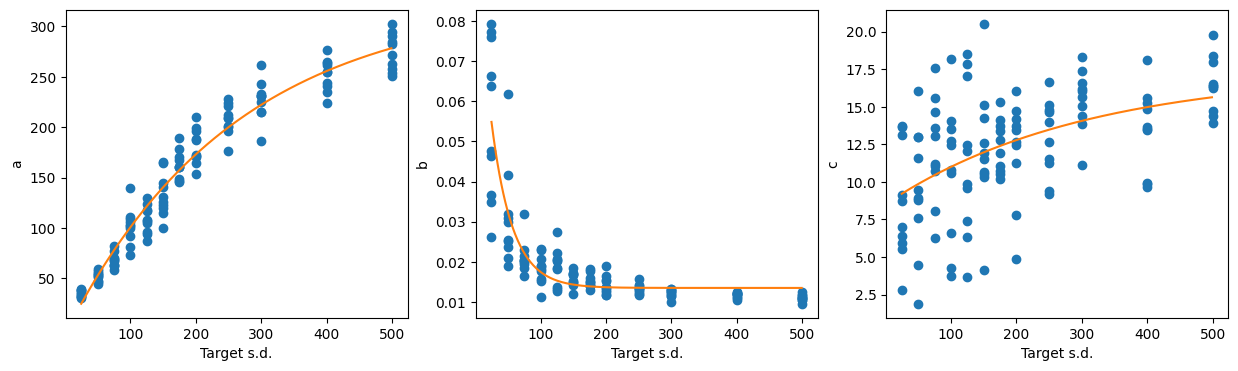

In [226]:
x = np.asarray([target_range for target_range, fit_params in params_long.items() for p in fit_params])
fig, axs = plt.subplots(1, 3, figsize=(15,4))

est_long = []
for i, ax in enumerate(axs):
    y = np.asarray([p[i] for target_range, fit_params in params_long.items() for p in fit_params])
    if i==0:
        mask = y<1000
        print((~mask).sum())
    else:
        mask = x>0
    ax.plot(x[mask], y[mask], 'o')
    fit, _ = curve_fit(exponential_offset, x[mask], y[mask], p0=[200, .01, 1] if i==0 else [-.1, .01, .1], maxfev=10000)
    ax.plot(np.arange(list(params_long.keys())[0], list(params_long.keys())[-1]), exponential_offset(np.arange(list(params_long.keys())[0], list(params_long.keys())[-1]), *fit))

    ax.set_xlabel('Target s.d.')
    ax.set_ylabel('abc'[i])
    
    est_long.append(fit)
est_long = np.asarray(est_long)
est_long

2


array([[ 1.86645520e+02,  4.38038718e-03,  2.79700097e+01],
       [-8.74016131e-02,  1.73822681e-02,  1.11607723e-01],
       [ 3.81714933e+03, -1.68805768e-06,  7.23849851e+00]])

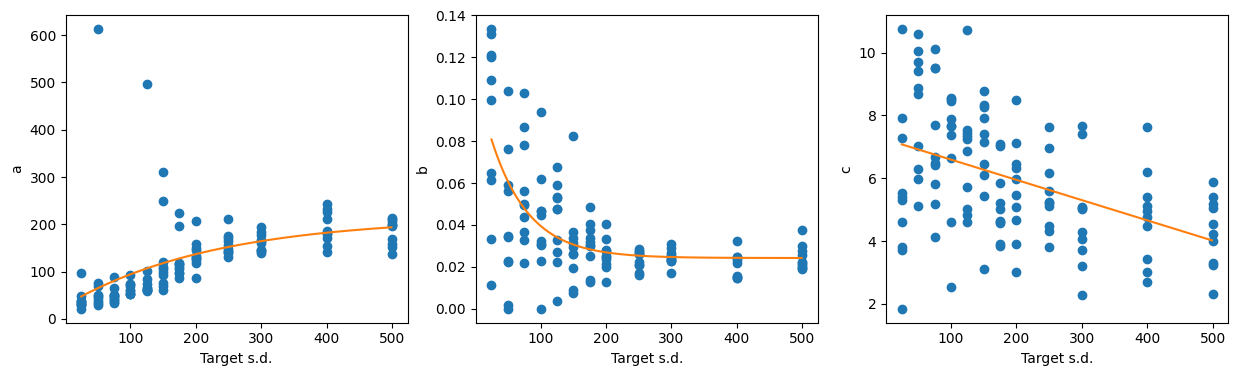

In [228]:
x = np.asarray([target_range for target_range, fit_params in params_short.items() for p in fit_params])
fig, axs = plt.subplots(1, 3, figsize=(15,4))

est_short = []
for i, ax in enumerate(axs):
    y = np.asarray([p[i] for target_range, fit_params in params_short.items() for p in fit_params])
    if i==0:
        mask = y<1000
        print((~mask).sum())
    else:
        mask = x>0
    ax.plot(x[mask], y[mask], 'o')
    fit, _ = curve_fit(exponential_offset, x[mask], y[mask], p0=[200, .01, 1] if i==0 else [-.1, .01, .1], maxfev=10000)
    ax.plot(np.arange(list(params_short.keys())[0], list(params_short.keys())[-1]), exponential_offset(np.arange(list(params_short.keys())[0], list(params_short.keys())[-1]), *fit))

    ax.set_xlabel('Target s.d.')
    ax.set_ylabel('abc'[i])
    
    est_short.append(fit)
est_short = np.asarray(est_short)
est_short

# AUT data check

In [86]:
dims = ('novelty', 'feasibility', 'value')

In [87]:
with open('shuf_elo.pkl', 'rb') as file:
    shuf_elo = pkl.load(file)
    elo = {dim: shuf_elo[0][dim] for dim in dims}

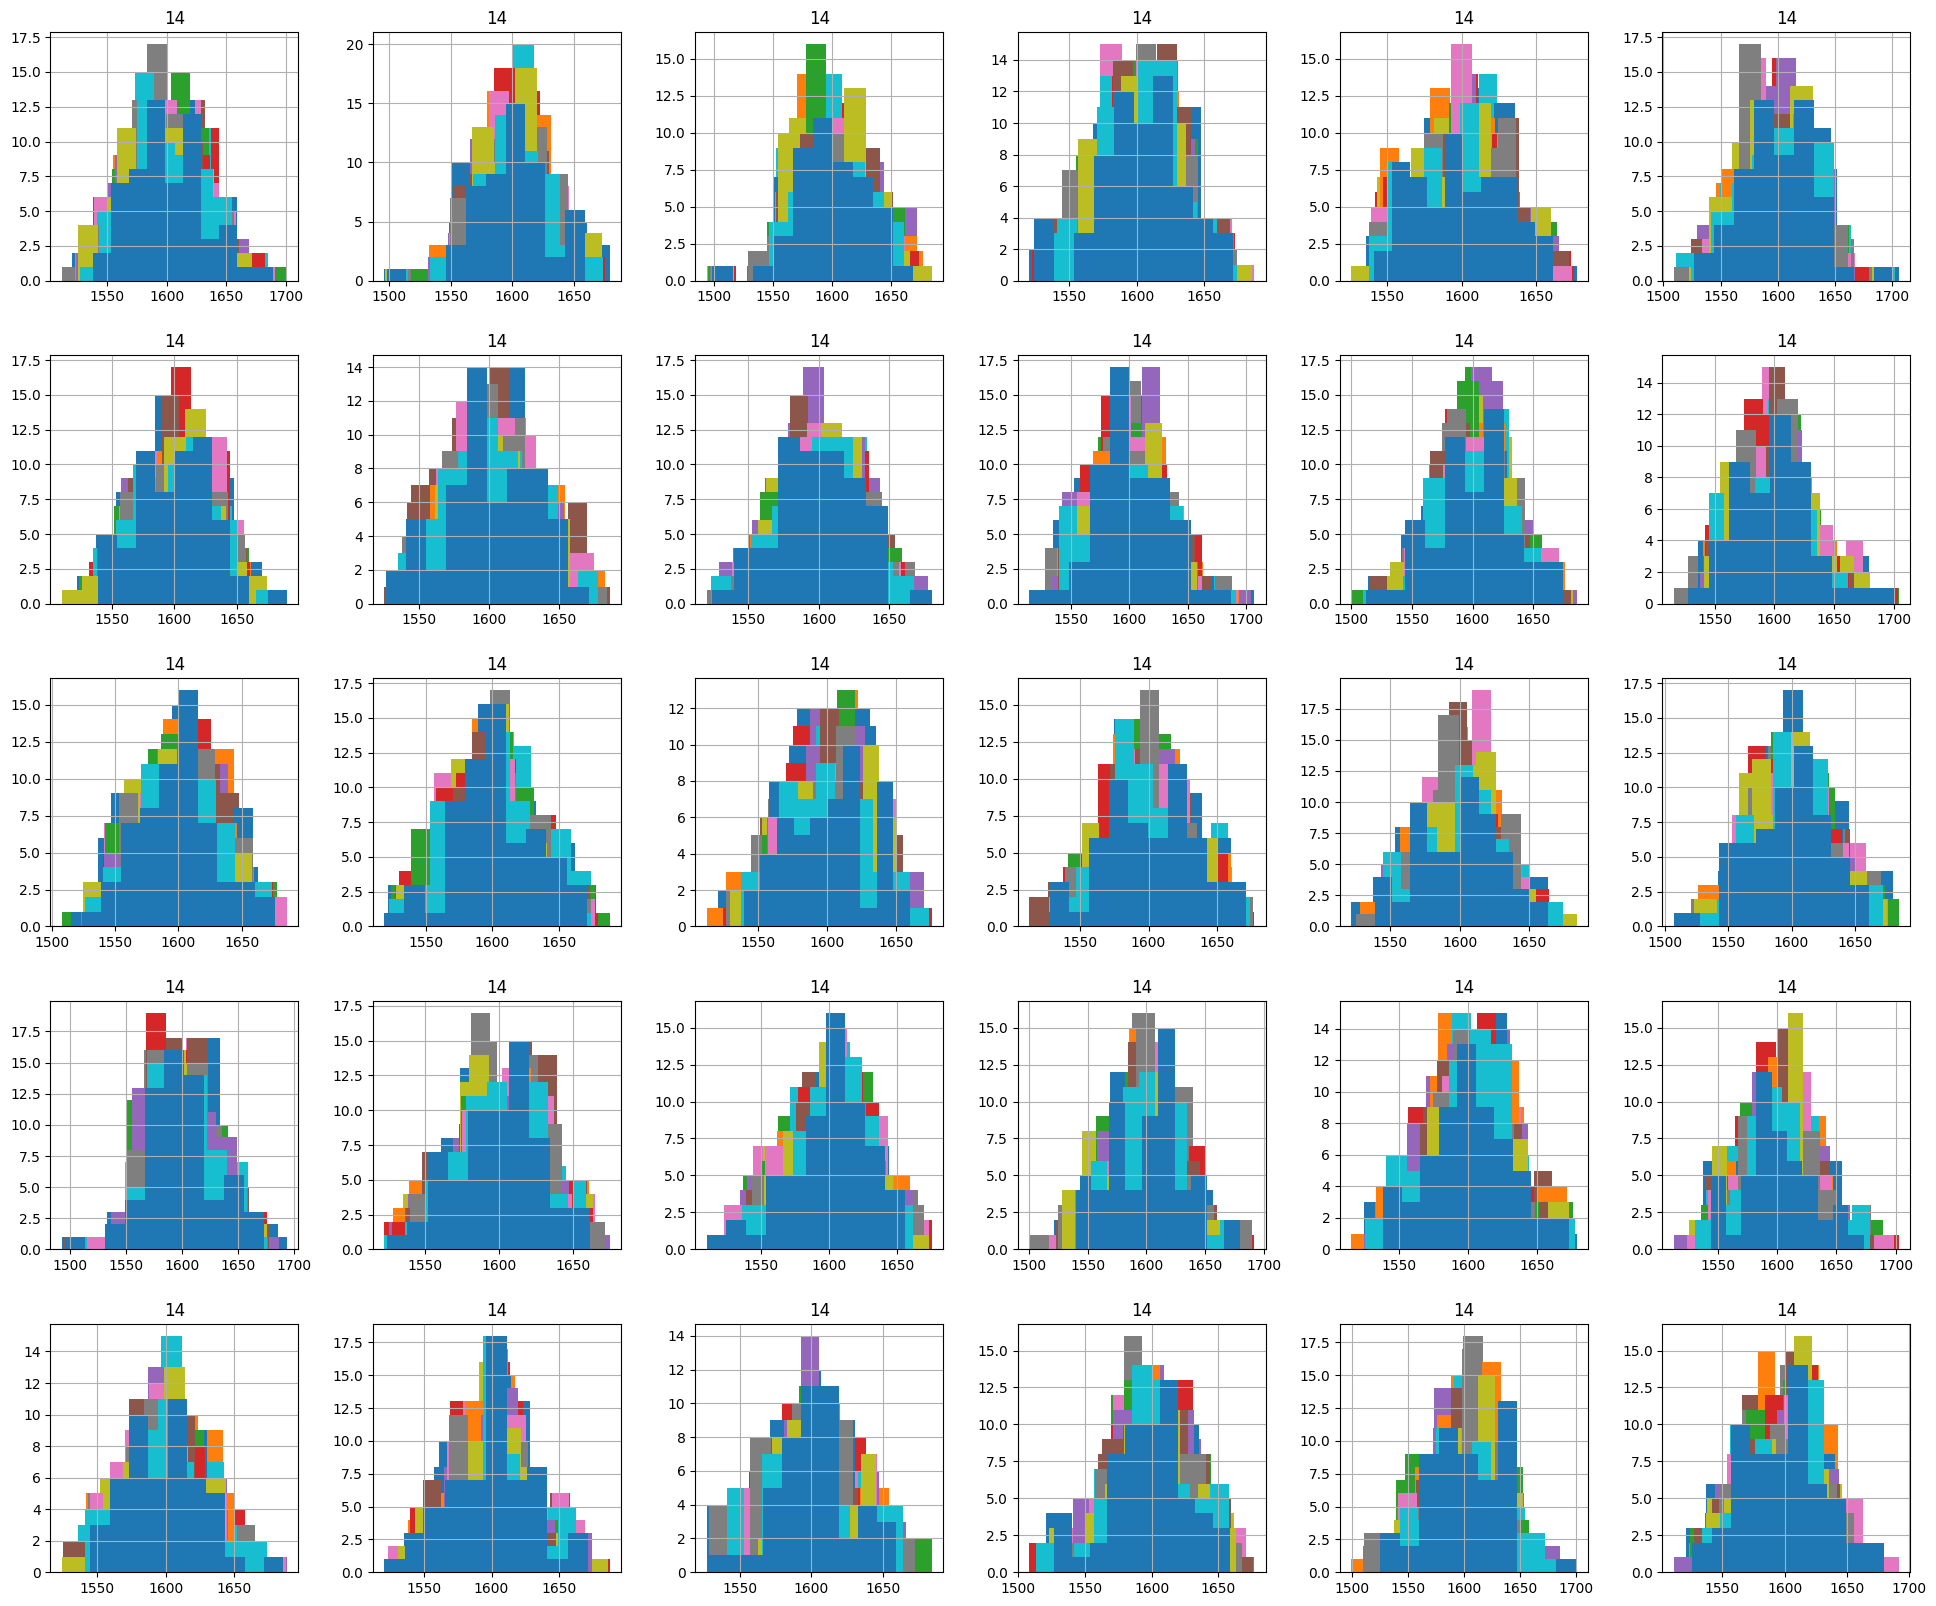

In [224]:
fig, axs = plt.subplots(5,6, figsize=(24,20))

for i, ax in enumerate(axs.ravel()):
    for eshuf in shuf_elo:
        rowmask = eshuf['novelty'].Item == i
        eshuf['novelty'][rowmask].hist(eshuf['novelty'].N.min(), ax=ax)

novelty [1.57670103e+03 7.82869161e-02 5.67121810e+00] [9.88694825e+03 4.04158059e-02 1.17805437e+00]
feasibility [9.67650592e+02 6.99898716e-02 5.82943159e+00] [7.43822153e+03 3.72976440e-02 1.16252287e+00]
value [1.72171201e+03 1.11391717e-01 4.95382705e+00] [9.89933998e+03 6.23508182e-02 1.14646610e+00]


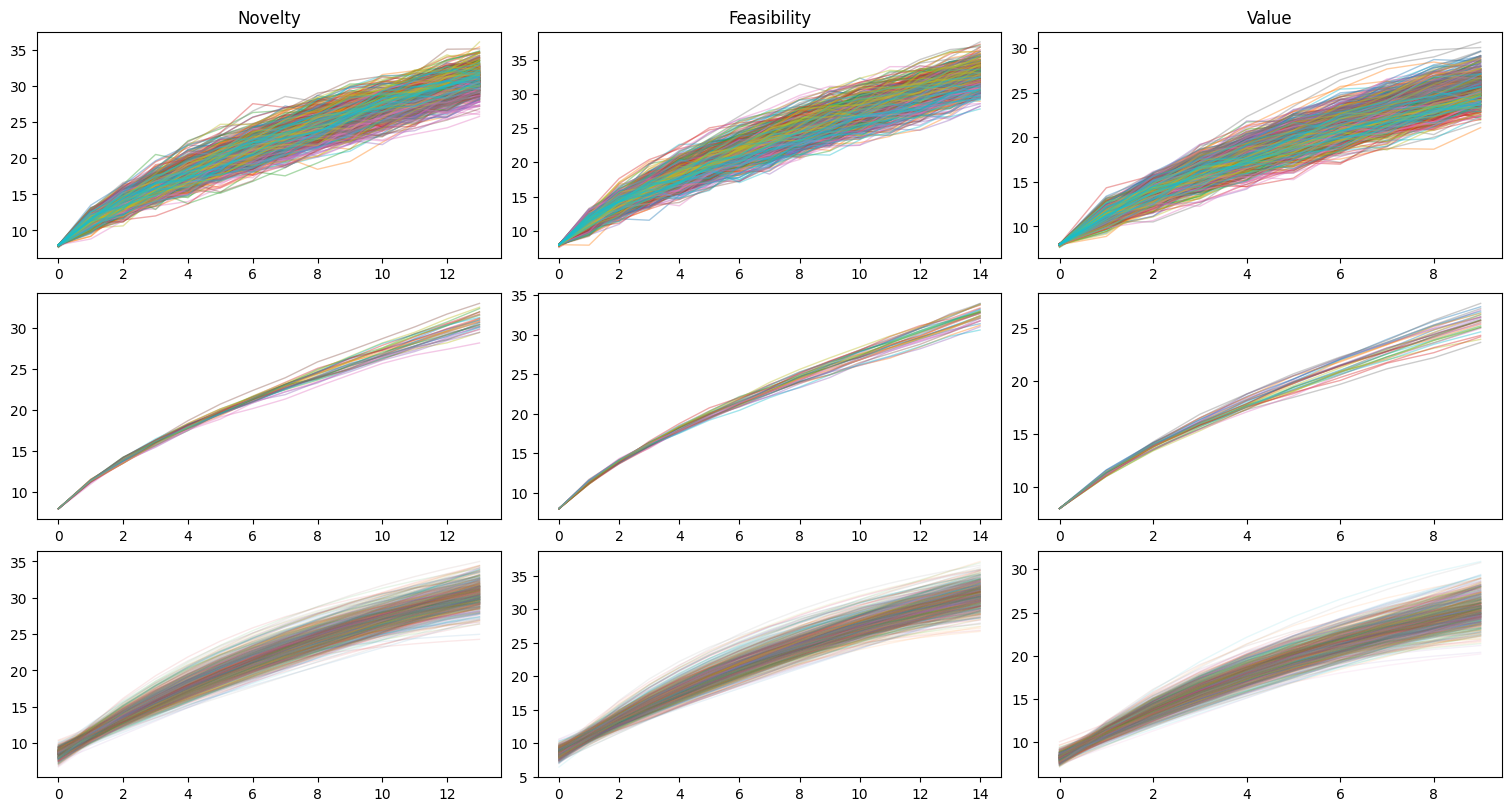

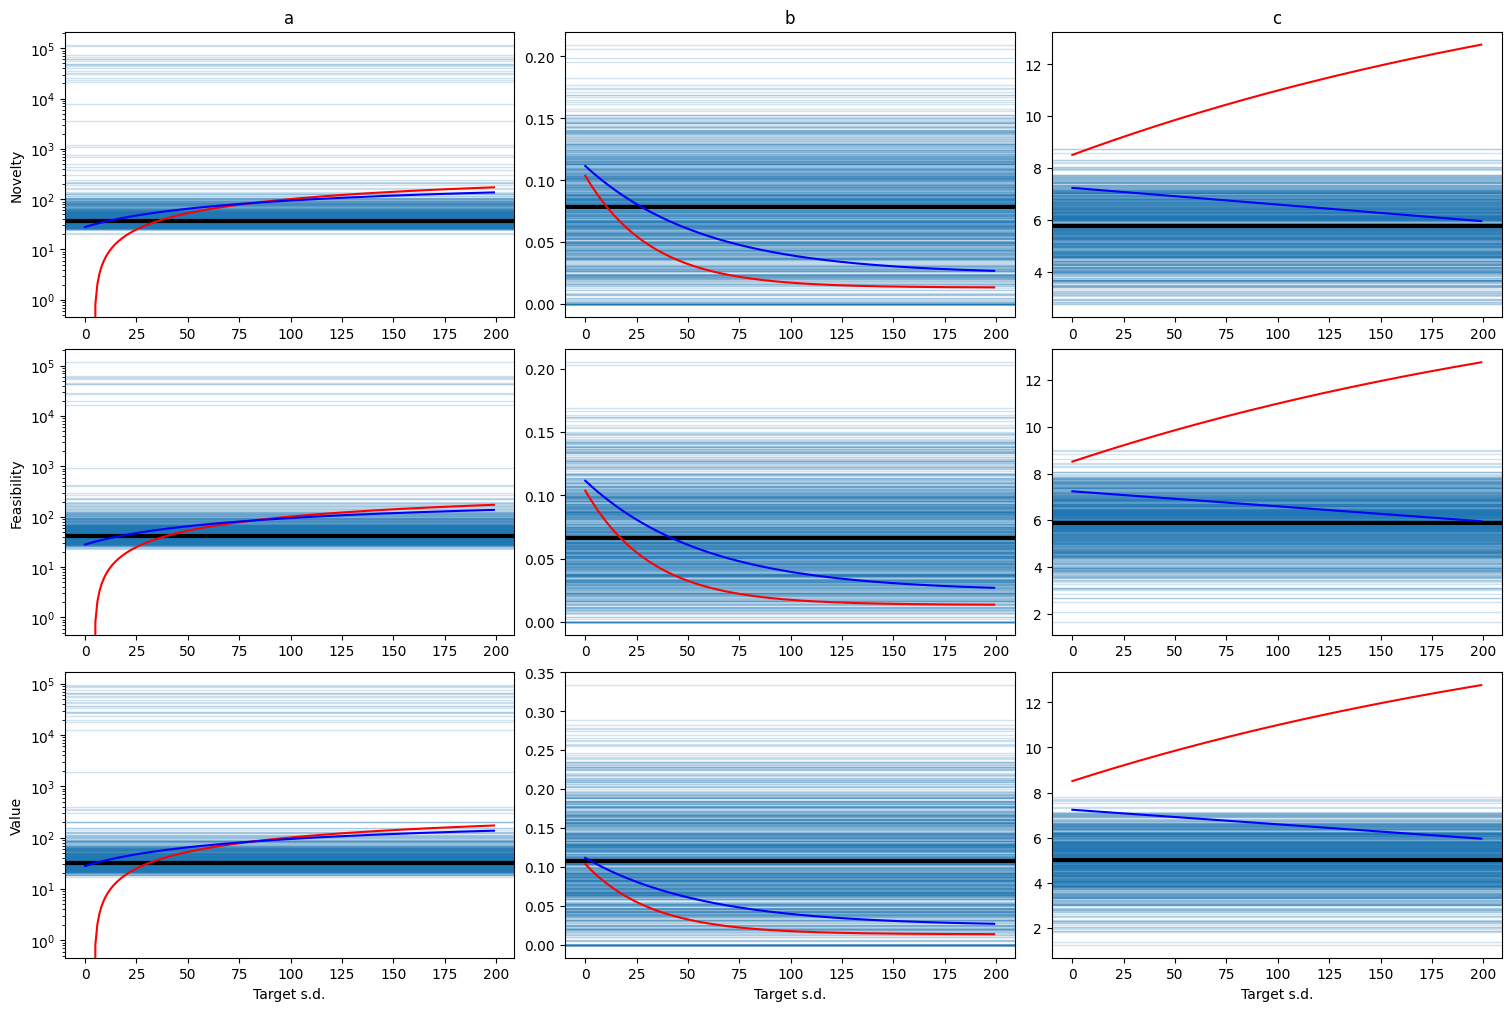

In [229]:
fig, axs = plt.subplots(3,3, figsize=(15,8), layout='constrained')
_, axs2 = plt.subplots(3,3, figsize=(15,10), layout='constrained')

for i, (dim, axc, axr2) in enumerate(zip(elo, axs.T, axs2)):
    axc[0].set_title(dim.capitalize())
    M = np.arange(elo[dim].N.min()) + 1
    fit_params = []
    for item in range(30):
        ax = axc[0]
        color = f'C{item%10}'
        stds = []
        for eshuf in shuf_elo:
            rowmask = eshuf[dim].Item == item
            std = np.empty(M.size)
            for m in M:
                std[m-1] = np.std(eshuf[dim][m][rowmask])
            axc[0].plot(std, c=color, alpha=.4, lw=1)
            stds.append(std)

            params_offset, _ = curve_fit(exponential_offset, M, std, p0=[200, .01, 8], maxfev=10000)
            fit = exponential_offset(M, *params_offset)
            axc[2].plot(fit, alpha=.1, lw=1)
            fit_params.append(params_offset)

        stds = np.mean(stds, axis=0)
        axc[1].plot(stds, alpha=.4, lw=1)
    
    print(dim, np.mean(fit_params, axis=0), np.std(fit_params, axis=0))

    for ax, pfit in zip(axr2, np.asarray(fit_params).T):
        for p in pfit:
            ax.axhline(p, lw=1, alpha=.2)
        ax.axhline(np.median(pfit), lw=3, color='k')
    axr2[0].set_ylabel(dim.capitalize())

for axr in axs2:
    axr[0].semilogy()

x = np.arange(200)
for i, axc2 in enumerate(axs2.T):
    axc2[0].set_title('abc'[i])
    axc2[-1].set_xlabel('Target s.d.')
    for ax in axc2:
        ax.plot(x, exponential_offset(x, *est_long[i]), c='r')
        ax.plot(x, exponential_offset(x, *est_short[i]), c='b')

This looks pretty bad. Our estimate of AUT ground-truth Elo rating standard deviation is <50 (note that parameter `a` is the most informative and trustworthy), which would require hundreds of matches to get to rho>0.9.

# Using the AUT matchmaking strategy

In [11]:
def randargsort(a):
    redirection = np.random.choice(a.size, a.shape, replace=False)
    return redirection[np.argsort(a[redirection])]

In [97]:
n = 40
half = n//2
matches = 30
chunk_size = 4
checkouts = n*matches // (2*chunk_size)
stdindicator_AUTelo = {}
for target_range in (25,50,75,100,250,500):
    stdindicator_AUTelo[target_range] = []
    for _ in range(50):
        elo_list = [pd.Series(np.full(n, 1600, int))]
        counts = np.zeros(n, int)
        latest_elo = np.full(n, 1600, int)
        target_elo = np.random.normal(1600, target_range, n).astype(int)
        for _ in range(checkouts):
            left = randargsort(counts)[:chunk_size]  # Indices of lowest counts, with shuffled ties
            right = []
            for i in left:
                elo_diff = np.abs(latest_elo - latest_elo[i])
                elo_diff[i] = -1  # Do not pair with self
                right.append(randargsort(elo_diff)[1])
            odds = elo_odds(target_elo[left], target_elo[right])
            dice = np.random.uniform(size=chunk_size)
            outcomes = odds > dice
            winners = np.where(outcomes, left, right)
            losers = np.where(outcomes, right, left)
            # Iterate, since right may contain duplicates of both right and left entries
            for winner, loser in zip(winners, losers):
                winner_elo, loser_elo = elo_match(latest_elo[winner], latest_elo[loser], k=16)
                for k, kelo in [(winner, winner_elo), (loser, loser_elo)]:
                    latest_elo[k] = kelo
                    counts[k] += 1
                    if len(elo_list) <= counts[k]:
                        elo_list.append(elo_list[-1].copy())
                    elo_list[counts[k]][k] = kelo
        df = pd.DataFrame({'target': target_elo, 'N': counts}).join(pd.concat(elo_list, axis=1))

        for i, row in df.iterrows():
            if row.N+1 in df:
                df.loc[i, row.N+1:] = row[row.N]
        
        stdindicator_AUTelo[target_range].append(df)

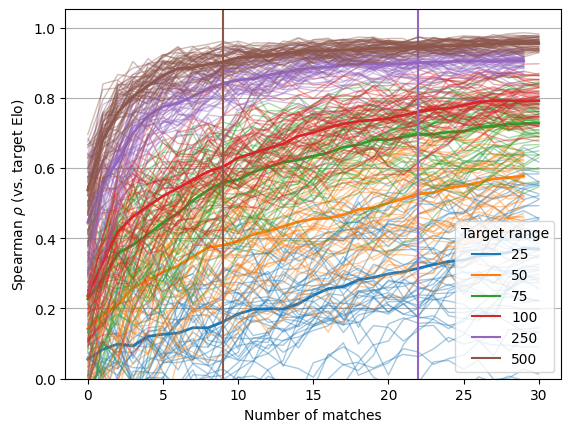

In [123]:
for i, (target_range, sim_elo) in enumerate(stdindicator_AUTelo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    corrs = []
    M = min([eshuf.N.max() for eshuf in sim_elo])
    for eshuf in sim_elo:
        corr = np.empty(M-1)
        for m in range(M-1):
            corr[m] = stats.spearmanr(eshuf[m+1], eshuf['target']).statistic
        plt.plot(corr, c=f'C{i}', alpha=.4, lw=1)
        corrs.append(corr)
    corrs = np.mean(corrs, axis=0)
    plt.plot(corrs, c=f'C{i}', lw=2)
    if (corrs > indicator).sum():
        plt.axvline(np.argmax(corrs > indicator), c=f'C{i}')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Spearman $\\rho$ (vs. target Elo)')
plt.ylim(0, None)
plt.legend(title='Target range')

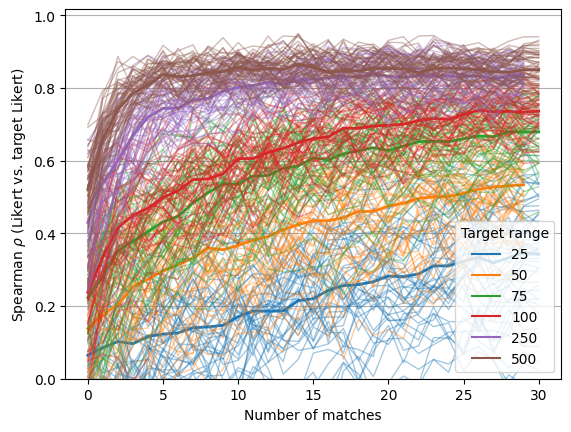

In [128]:
likert = lambda val: np.digitize(val, np.linspace(val.min(), val.max()+.1, 6))
for i, (target_range, sim_elo) in enumerate(stdindicator_AUTelo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    corrs = []
    M = min([eshuf.N.max() for eshuf in sim_elo])
    for eshuf in sim_elo:
        target = likert(eshuf.target)
        corr = np.empty(M-1)
        for m in range(M-1):
            corr[m] = stats.spearmanr(likert(eshuf[m+1]), target).statistic
        plt.plot(corr, c=f'C{i}', alpha=.4, lw=1)
        corrs.append(corr)
    corrs = np.mean(corrs, axis=0)
    plt.plot(corrs, c=f'C{i}', lw=2)
    if (corrs > indicator).sum():
        plt.axvline(np.argmax(corrs > indicator), c=f'C{i}')

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Spearman $\\rho$ (Likert vs. target Likert)')
plt.ylim(0, None)
plt.legend(title='Target range')


 25
Exp 68.21617713193135 2.488659726744579
Offset 28.47706528881769 2.921010329384281
	params [1.14573554e+02 8.03263810e-03 1.71713630e+01]

 50
Exp 67.83803605932597 3.9934537253902067
Offset 27.379661890397973 1.866526399858887
	params [1.17780586e+02 7.78094505e-03 1.70231050e+01]

 75
Exp 67.6019899776553 2.33601922669184
Offset 27.482847826959425 1.4915645293407764
	params [1.16575262e+02 7.94378983e-03 1.69799798e+01]

 100
Exp 68.72664858852404 3.823306721941377
Offset 27.3365952344334 2.3052866459143093
	params [1.20430653e+02 7.67868713e-03 1.71362472e+01]

 500
Exp 70.27135039919958 4.338236956019273
Offset 30.533465828909733 4.26049648018539
	params [1.36103964e+02 8.17669362e-03 1.71440386e+01]


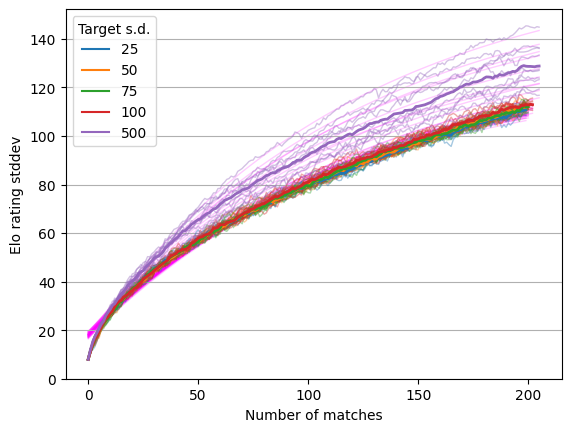

In [60]:
params_AUT = {}
for i, (target_range, sim_elo) in enumerate(stdindicator_AUTelo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    stds = []
    err_exp, err_offset = [], []
    fit_params = []
    M = np.arange(min([eshuf.N.max() for eshuf in sim_elo])-1) + 1
    for eshuf in sim_elo:
        # M = np.arange(eshuf.columns[-1]-1) + 1
        std = np.empty(M.size)
        for m in M:
            std[m-1] = np.std(eshuf[m])
        plt.plot(std, c=f'C{i}', alpha=.4, lw=1)
        stds.append(std)
        
        params_exp, _ = curve_fit(exponential_growth, M, std, p0=[200, .01], maxfev=10000)
        fit = exponential_growth(M, *params_exp)
        # plt.plot(fit, c='magenta', alpha=.2, lw=1, zorder=-1)
        err_exp.append(np.sqrt(np.sum((fit-std)**2)))

        params_offset, _ = curve_fit(exponential_offset, M, std, p0=[200, .01, 0], maxfev=10000)
        fit = exponential_offset(M, *params_offset)
        plt.plot(fit, c='magenta', alpha=.2, lw=1, zorder=-1)
        err_offset.append(np.sqrt(np.sum((fit-std)**2)))
        fit_params.append(params_offset)

    stds = np.mean(stds, axis=0)
    plt.plot(stds, c=f'C{i}', lw=2, zorder=10)

    print('\n', target_range)
    print('Exp', np.mean(err_exp), np.std(err_exp))
    print('Offset', np.mean(err_offset), np.std(err_offset))
    print('\tparams', np.mean(fit_params, axis=0))
    params_AUT[target_range] = fit_params

plt.gca().yaxis.grid()

plt.xlabel('Number of matches')
plt.ylabel('Elo rating stddev')
plt.ylim(0, None)
plt.legend(title='Target s.d.')

0


array([[ 3.58834908e+01,  2.05531454e-03,  1.13065356e+02],
       [-2.49792396e+00,  3.92284084e-01,  2.50581899e+00],
       [ 1.90921871e+01,  7.17166679e-06,  1.70704240e+01]])

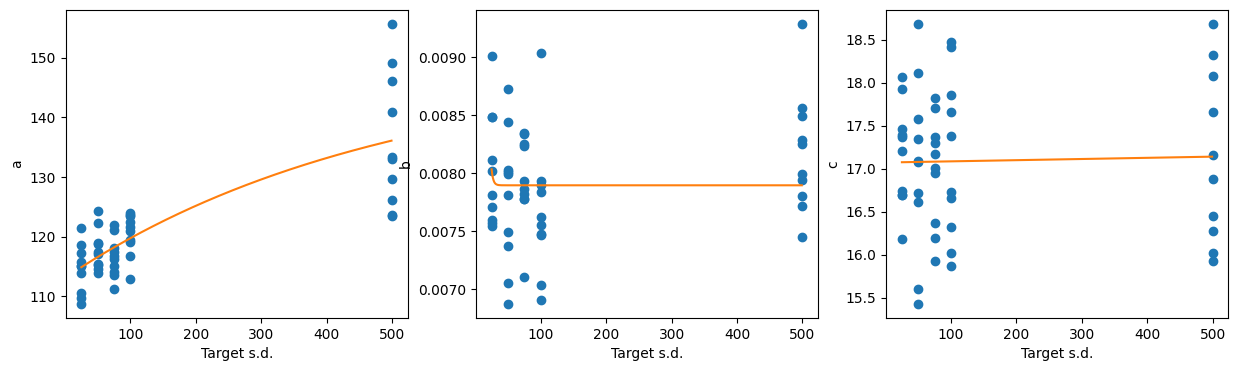

In [61]:
x = np.asarray([target_range for target_range, fit_params in params_AUT.items() for p in fit_params])
fig, axs = plt.subplots(1, 3, figsize=(15,4))

est_AUT = []
for i, ax in enumerate(axs):
    y = np.asarray([p[i] for target_range, fit_params in params_AUT.items() for p in fit_params])
    if i==0:
        mask = y<1000
        print((~mask).sum())
    else:
        mask = x>0
    ax.plot(x[mask], y[mask], 'o')
    fit, _ = curve_fit(exponential_offset, x[mask], y[mask], p0=[200, .01, 1] if i==0 else [-.1, .01, .1], maxfev=10000)
    ax.plot(np.arange(list(params_AUT.keys())[0], list(params_AUT.keys())[-1]), exponential_offset(np.arange(list(params_AUT.keys())[0], list(params_AUT.keys())[-1]), *fit))

    ax.set_xlabel('Target s.d.')
    ax.set_ylabel('abc'[i])
    
    est_AUT.append(fit)
est_AUT = np.asarray(est_AUT)
est_AUT

Oh no. Replicating the match-making strategy used for the AUT ratings, the standard deviation of ratings over time actually tells us absolutely nothing at all about the underlying distribution.

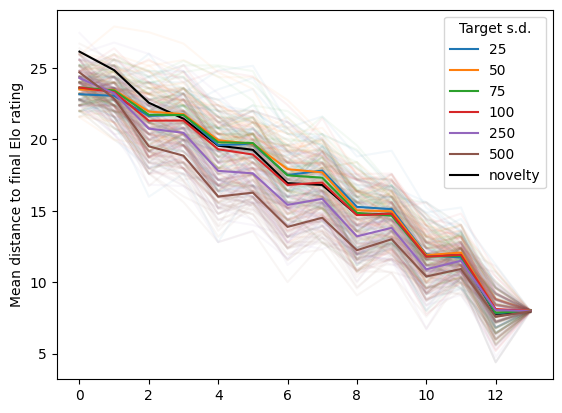

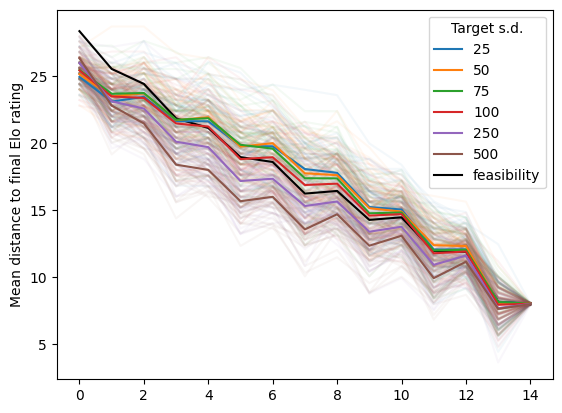

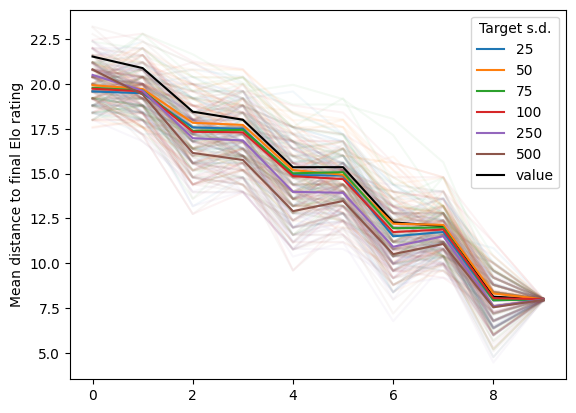

In [104]:
for dim in dims:
    plt.figure()
    N = elo[dim].N.min()

    for i, (target_range, sim_elo) in enumerate(stdindicator_AUTelo.items()):
        plt.plot([], c=f'C{i}', label=target_range)
        themanylines = []
        for eshuf in sim_elo:
            thelines = []
            for _, row in eshuf.iterrows():
                theline = [row[N] - row[i] for i in range(N)]
                thelines.append(theline)
            plt.plot(np.mean(np.abs(thelines), axis=0), c=f'C{i}', alpha=.05)
            themanylines.extend(thelines)
        plt.plot(np.mean(np.abs(themanylines), axis=0), c=f'C{i}', zorder=10)

    thelines = []
    for _, row in elo[dim].iterrows():
        theline = [row[N] - row[i] for i in range(N)]
        thelines.append(theline)
    plt.plot(np.mean(np.abs(thelines), axis=0), label=dim, c='k')

    plt.legend(title='Target s.d.')
    plt.ylabel('Mean distance to final Elo rating')

While AUT data is easily within the standard deviation of even very large ground-truth variances, the trend suggests an s.d. < 100 to me.

Text(0, 0.5, 'Mean distance to final Elo rating')

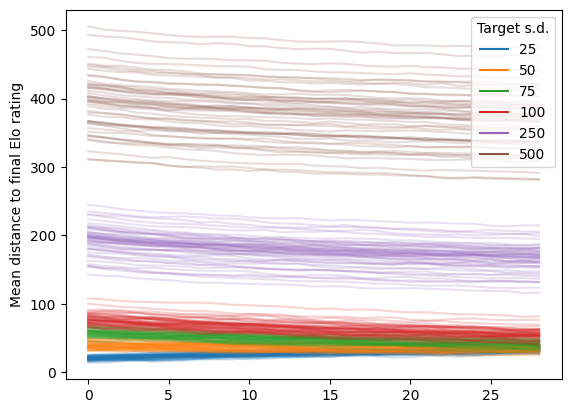

In [115]:
for i, (target_range, sim_elo) in enumerate(stdindicator_AUTelo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    for eshuf in sim_elo:
        thelines = []
        for _, row in eshuf.iterrows():
            theline = [row.target - row[i] for i in range(row.N)]
            thelines.append(theline[-eshuf.N.min():])
        plt.plot(np.mean(np.abs(thelines), axis=0), c=f'C{i}', alpha=.2)
plt.legend(title='Target s.d.')
plt.ylabel('Mean distance to final Elo rating')

Text(0, 0.5, 'Mean distance to final Elo rating')

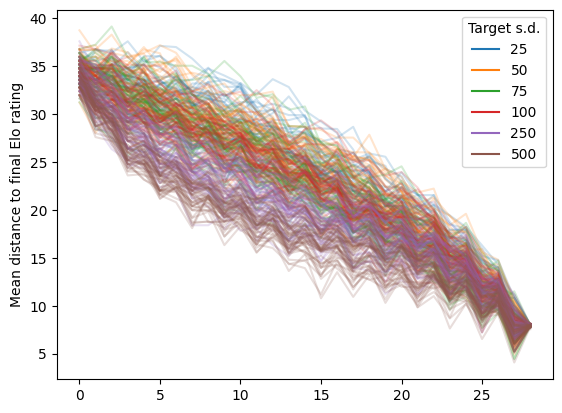

In [105]:
for i, (target_range, sim_elo) in enumerate(stdindicator_AUTelo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    for eshuf in sim_elo:
        thelines = []
        for _, row in eshuf.iterrows():
            theline = [row[row.N] - row[i] for i in range(row.N)]
            thelines.append(theline[-eshuf.N.min():])
        plt.plot(np.mean(np.abs(thelines), axis=0), c=f'C{i}', alpha=.2)
plt.legend(title='Target s.d.')
plt.ylabel('Mean distance to final Elo rating')

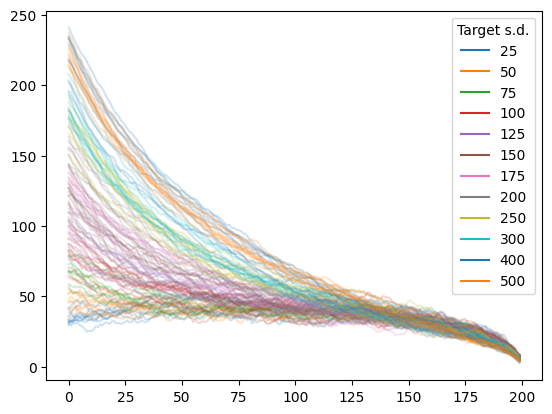

In [112]:
for i, (target_range, sim_elo) in enumerate(stdindicator_elo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    for eshuf in sim_elo:
        thelines = []
        for _, row in eshuf.iterrows():
            theline = [row[200] - row[i] for i in range(200)]
            thelines.append(theline)
        plt.plot(np.mean(np.abs(thelines), axis=0), c=f'C{i}', alpha=.2)
plt.legend(title='Target s.d.')

Another indicator that looks like it'd have said something for the match-count bias strategy, but is meaningless in the AUT strategy unless at least 2-3x more data is collected.

Text(0, 0.5, 'Mean rank change')

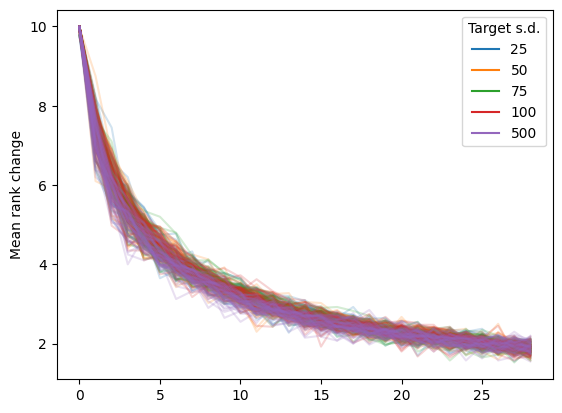

In [73]:
for i, (target_range, sim_elo) in enumerate(stdindicator_AUTelo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    for eshuf in sim_elo:
        thelines = []
        ranks = pd.DataFrame()
        N = eshuf.N.min()
        for col in range(N+1):
            ranks[col] = eshuf[col].rank(method='average')
        for _, row in ranks.iterrows():
            theline = [row[i] - row[i+1] for i in range(N)]
            thelines.append(theline)
        plt.plot(np.mean(np.abs(thelines), axis=0), c=f'C{i}', alpha=.2)
plt.legend(title='Target s.d.')
plt.ylabel('Mean rank change')

Text(0, 0.5, 'Mean rank change')

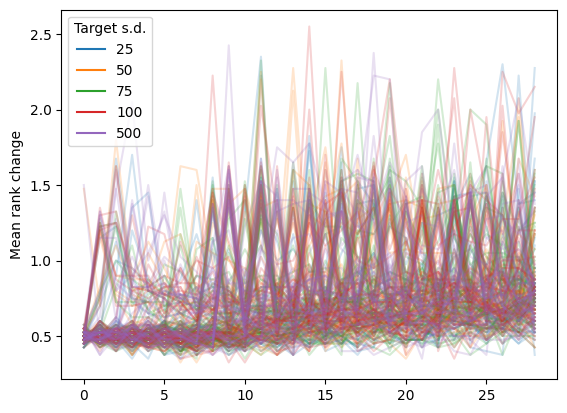

In [74]:
for i, (target_range, sim_elo) in enumerate(stdindicator_AUTelo.items()):
    plt.plot([], c=f'C{i}', label=target_range)
    for eshuf in sim_elo:
        thelines = []
        ranks = pd.DataFrame()
        N = eshuf.N.min()
        for col in range(N+1):
            ranks[col] = eshuf[col].rank(method='dense')
        for _, row in ranks.iterrows():
            theline = [row[i] - row[i+1] for i in range(N)]
            thelines.append(theline)
        plt.plot(np.mean(np.abs(thelines), axis=0), c=f'C{i}', alpha=.2)
plt.legend(title='Target s.d.')
plt.ylabel('Mean rank change')

Rank changes relax exponentially, driven mainly by progressive fine-graining, but offer absolutely no insight.